In [1]:
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import netCDF4
import scipy
import pandas as pd
from datetime import datetime
import seaborn as sns
from netCDF4 import Dataset

In [149]:
fdir = '/Users/peizhangcheng/Desktop/ALCF/MQI_Ceilometer/Macquarie Island (CL51)/raw/2018-01-02T2300.nc'
cl = xr.open_dataset(fdir)

In [2]:
fdir = xr.open_mfdataset('/Users/peizhangcheng/Desktop/ALCF/MQI_Ceilometer/Macquarie Island (CL51)/processed/lidar/2017-09-01T000000.nc')

In [7]:
fdir

<xarray.Dataset>
Dimensions:         (bnds: 2, level: 300, range: 300, time: 288)
Coordinates:
  * time            (time) datetime64[ns] 2017-09-01T00:02:29.999991 ... 2017...
Dimensions without coordinates: bnds, level, range
Data variables:
    time_bnds       (time, bnds) datetime64[ns] dask.array<chunksize=(288, 2), meta=np.ndarray>
    zfull           (level) float64 dask.array<chunksize=(300,), meta=np.ndarray>
    backscatter     (time, level) float64 dask.array<chunksize=(288, 300), meta=np.ndarray>
    altitude        (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
    lon             (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
    lat             (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
    backscatter_sd  (time, range) float64 dask.array<chunksize=(288, 300), meta=np.ndarray>
    cloud_mask      (time, level) int8 dask.array<chunksize=(288, 300), meta=np.ndarray>
    cbh             (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
    lr              (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>

In [8]:
fdir = xr.open_mfdataset('/Users/peizhangcheng/Desktop/ALCF/MQI_Ceilometer/Macquarie Island (CL51)/processed/lidar/*')

In [20]:
fdir = fdir.assign_coords(level=fdir.zfull[0].values)

In [21]:
fdir.cloud_mask

<xarray.DataArray 'cloud_mask' (time: 52417, level: 300)>
dask.array<concatenate, shape=(52417, 300), dtype=int8, chunksize=(289, 300), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2017-09-01T00:02:29.999991 ... 2018-03-01T...
  * level    (level) float64 25.0 75.0 125.0 ... 1.488e+04 1.492e+04 1.498e+04
Attributes:
    long_name:  cloud mask
    units:      1

In [39]:
sta = xr.open_dataset('/Users/peizhangcheng/Desktop/ALCF/MQI_Ceilometer/Macquarie Island (CL51)/processed/stats/all.nc')

In [150]:
cl

<xarray.Dataset>
Dimensions:               (layer: 5, level: 1540, time: 374)
Coordinates:
  * time                  (time) datetime64[ns] 2018-01-02T23:22:44 ... 2018-...
  * level                 (level) int32 0 1 2 3 4 5 ... 1535 1536 1537 1538 1539
  * layer                 (layer) int32 0 1 2 3 4
Data variables: (12/30)
    time_utc              (time) object ...
    backscatter           (time, level) float32 ...
    unit                  (time) |S1 ...
    software_level        (time) float64 ...
    message_number        (time) float64 ...
    message_subclass      (time) float64 ...
    ...                    ...
    pulse_count           (time) float64 ...
    receiver_gain         (time) |S1 ...
    receiver_bandwidth    (time) |S1 ...
    backscatter_sum       (time) float32 ...
    layer_height          (time, layer) float64 ...
    layer_cloud_amount    (time, layer) float64 ...
Attributes:
    software:  cl2nc (https://github.com/peterkuma/cl2nc)
    version:   3.0.0
    created:   2018-10-10T06:57:41Z

In [148]:
sta

<xarray.Dataset>
Dimensions:              (backscatter_full: 39, backscatter_sd_full: 13, zfull: 150)
Coordinates:
  * zfull                (zfull) float64 50.0 150.0 ... 1.485e+04 1.495e+04
  * backscatter_full     (backscatter_full) float64 7.5e-06 ... 0.0001975
  * backscatter_sd_full  (backscatter_sd_full) float64 1.5e-09 ... 6.144e-06
Data variables:
    cl                   (zfull) float64 59.84 48.96 41.69 37.35 ... 0.0 0.0 0.0
    clt                  float64 93.95
    n                    int64 46725
    backscatter_avg      (zfull) float64 2.392e-05 1.06e-05 ... -2.653e-08
    backscatter_mol_avg  (zfull) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    backscatter_hist     (backscatter_full, zfull) float64 0.08683 ... 0.0
    backscatter_sd_hist  (backscatter_sd_full) float64 0.01344 0.02365 ... 0.0
    backscatter_sd_z     float64 7.975e+03

In [175]:
fdir = fdir.assign_coords(level=fdir.zfull[1,:].values)

In [176]:
def calc_cfad(obj, variable, height_variable=None, xbins=None):
    """
    Function for calculating CFAD

    Parameters
    ----------
    object : Xarray.Dataset
        ACT object containing vertical point data
    variable : string
        Variable to calculate CFAD
    height_variable : string
        Name of the height variable to use. If set to None, will attempt to determine
        by using coordinate varible name.
    xbins : list
        List of bins to calculate CFAD. If None will calcualte a default.

    Returns
    -------
    data_array : Xarray.DataArray
        DataArray containg results from CFAD analysis and coordinate variables

    """
    # Determine height coordinate varible name.
    if height_variable is None:
        height_variable = get_height_variable_name(obj, variable)

    data = obj[variable]
    height = obj[height_variable]

    if xbins is None:
        xbins = np.linspace(-70, 50, 121)

    dsk = []
    for j in range(len(height)):
        a = dask.delayed(np.histogram)(data[:, j], bins=xbins)
        dsk.append(a[0])

    hist = dask.compute(*dsk)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning,
                                message='.*divide by zero encountered in log10.*')
        hist = np.log10(np.array(hist))

    coords = {'x': xbins[:-1], height_variable: height}
    dims = [height_variable, "x"]
    attrs = {'long_name': f'CFAD for {variable}', 'units': '1'}

    data_array = xr.DataArray(data=hist, dims=dims, coords=coords, attrs=attrs)
    data_array['x'].attrs = {'long_name': 'X bins for CFAD', 'units': '1'}

    return data_array

def plot_cfad(hist, x, y):
    """
    Function for plotting up CFAD given 2D histogram, x, and y

    Parameters
    ----------
    hist : list
        2D list of histogram data from calc_cfad
    x : list
        List of x values
    y : list
        List of y values

    Returns
    -------
    fig : matplotlib ax handle
        Returns the axis handle for additional updates if needed

    """

    fig, ax = plt.subplots(dpi=100)
    cs = ax.contourf(x, y, hist, 50)
    cb = fig.colorbar(cs)
    cb.set_label('Density')

    return ax

In [177]:
import dask
import numpy as np
import warnings
import matplotlib.pyplot as plt
import xarray as xr

In [182]:
cfad_obs = calc_cfad(fdir.backscatter.to_dataset(), 'backscatter',height_variable='level',xbins=np.linspace(0,2e-4,1000))

Text(0, 0.5, 'Height (m)')

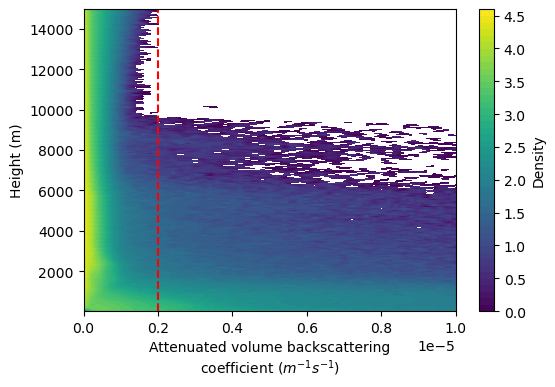

In [186]:
dims = cfad_obs.dims
plot_cfad(cfad_obs, cfad_obs[dims[1]], cfad_obs[dims[0]])
plt.xlim(0,0.00001)
plt.axvline(x=2*10**(-6), color='red', linestyle='--')
plt.xlabel('Attenuated volume backscattering\ncoefficient ($m^{-1}  s^{-1}$)')
plt.ylabel('Height (m)')

# plt.xlim(-35,25)
# plt.xlabel('dBZ')
# plt.ylabel('Height (m)')
# plt.title('Observation')
#plt.savefig('/Users/peizhangcheng/Desktop/cfad_backscattering.png')

In [84]:
fdir.backscatter[:,0]

<xarray.DataArray 'backscatter' (time: 288)>
array([4.683444e-06, 4.595484e-06, 4.496511e-06, ..., 3.276508e-06,
       2.961376e-06, 2.753336e-06])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01T00:02:29.999991 ... 2018-01-01T...
Attributes:
    long_name:  total attenuated volume backscattering coefficient
    units:      m-1 sr-1

In [78]:
fdir.backscatter.values.reshape(-1)

array([4.68344429e-06, 4.46502232e-06, 4.19805311e-06, ...,
       2.67903841e-08, 1.94159696e-07, 9.08986074e-08])

In [76]:
np.histogram2d(fdir.backscatter.values,fdir.backscatter.level.values,bins=200)

ValueError: x and y must have the same length.

In [69]:
np.linspace(0,fdir.backscatter.values.max(),1000)

array([0.00000000e+00, 2.37898644e-07, 4.75797288e-07, 7.13695932e-07,
       9.51594576e-07, 1.18949322e-06, 1.42739186e-06, 1.66529051e-06,
       1.90318915e-06, 2.14108780e-06, 2.37898644e-06, 2.61688508e-06,
       2.85478373e-06, 3.09268237e-06, 3.33058101e-06, 3.56847966e-06,
       3.80637830e-06, 4.04427695e-06, 4.28217559e-06, 4.52007423e-06,
       4.75797288e-06, 4.99587152e-06, 5.23377017e-06, 5.47166881e-06,
       5.70956745e-06, 5.94746610e-06, 6.18536474e-06, 6.42326339e-06,
       6.66116203e-06, 6.89906067e-06, 7.13695932e-06, 7.37485796e-06,
       7.61275660e-06, 7.85065525e-06, 8.08855389e-06, 8.32645254e-06,
       8.56435118e-06, 8.80224982e-06, 9.04014847e-06, 9.27804711e-06,
       9.51594576e-06, 9.75384440e-06, 9.99174304e-06, 1.02296417e-05,
       1.04675403e-05, 1.07054390e-05, 1.09433376e-05, 1.11812363e-05,
       1.14191349e-05, 1.16570336e-05, 1.18949322e-05, 1.21328308e-05,
       1.23707295e-05, 1.26086281e-05, 1.28465268e-05, 1.30844254e-05,
      

In [67]:
fdir.backscatter.values.max()

0.00023766074524748959

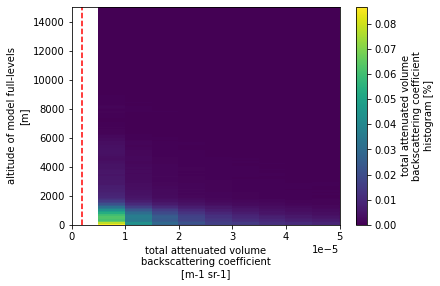

In [52]:
sta.backscatter_hist.transpose().plot()
plt.xlim(0,0.5*10**(-4))
plt.axvline(x=2*10**(-6), color='red', linestyle='--')

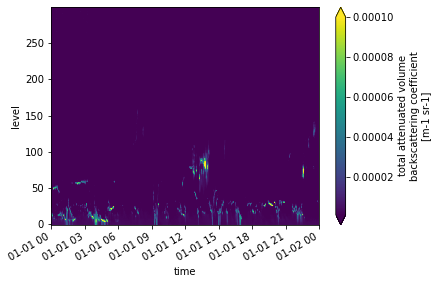

In [37]:
fdir.backscatter.transpose().plot(vmin=10e-7,vmax=10e-5,extend='both')

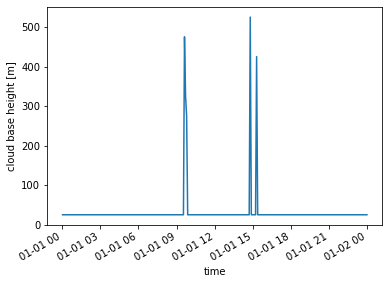

In [8]:
fdir.cbh.plot()

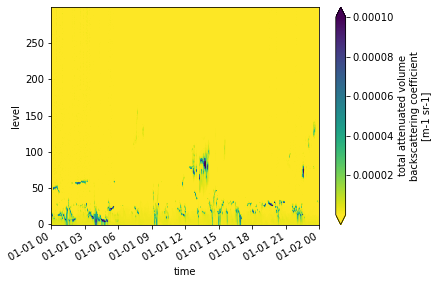

In [33]:
fdir.backscatter.transpose().plot(vmin=1e-7,vmax=1e-4,cmap='viridis_r')

In [5]:
fdir = '/Volumes/My Passport/ALCF/alcf-tutorial-datasets/ACCESS_SWbias_neg/model2/model2.nc'
new_model = xr.open_dataset(fdir)

In [6]:
fdir = '/Volumes/My Passport/ALCF/alcf-tutorial-datasets/ACCESS-AM2/processed/model/2017-09-03T000000.nc'
old_model = xr.open_dataset(fdir)

In [7]:
new_model

<xarray.Dataset>
Dimensions:    (bnds: 2, level: 85, time: 433)
Coordinates:
  * time       (time) datetime64[ns] 2017-09-02T22:00:00.000027 ... 2018-02-2...
Dimensions without coordinates: bnds, level
Data variables:
    lat        (time) float64 ...
    lon        (time) float64 ...
    ps         (time) float32 ...
    ta         (time, level) float32 ...
    cl         (time, level) float32 ...
    pfull      (time, level) float32 ...
    clw        (time, level) float32 ...
    cli        (time, level) float32 ...
    zfull      (time, level) float64 ...
    orog       (time) float64 ...
    time_bnds  (time, bnds) datetime64[ns] ...

In [8]:
old_model

<xarray.Dataset>
Dimensions:    (bnds: 2, level: 85, time: 25)
Coordinates:
  * time       (time) datetime64[ns] 2017-09-03T00:15:00.000027 ... 2017-09-0...
Dimensions without coordinates: bnds, level
Data variables:
    lat        (time) float64 -54.38 -54.38 -54.38 ... -54.38 -54.38 -54.38
    lon        (time) float64 158.4 158.4 158.4 158.4 ... 158.4 158.4 158.4
    ps         (time) float32 1.003e+05 1.003e+05 ... 9.878e+04 9.876e+04
    ta         (time, level) float32 278.3 278.0 277.5 ... 191.3 179.7 163.7
    cl         (time, level) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    pfull      (time, level) float32 1.001e+05 9.968e+04 ... 0.5088 0.1565
    clw        (time, level) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    cli        (time, level) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    zfull      (time, level) float64 20.0 53.33 100.0 ... 7.91e+04 8.5e+04
    orog       (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    time_bnds  (time, bnds) datetime64[ns] 2017-09-03 ... 2017-09-04

In [41]:
fdir = '/Volumes/My Passport/ALCF/alcf-tutorial-datasets/ACCESS-AM2/processed/simulate/2017-09-01T000000.nc'
old_simulate = xr.open_dataset(fdir)

In [42]:
old_simulate

<xarray.Dataset>
Dimensions:          (bnds: 2, column: 10, level: 85, time: 24)
Coordinates:
  * time             (time) float64 2.458e+06 2.458e+06 ... 2.458e+06 2.458e+06
Dimensions without coordinates: bnds, column, level
Data variables:
    lon              (time) float64 ...
    lat              (time) float64 ...
    altitude         (time) float64 ...
    zfull            (time, level) float64 ...
    pfull            (time, level) float64 ...
    backscatter      (time, level, column) float64 ...
    backscatter_mol  (time, level) float64 ...
    time_bnds        (time, bnds) float64 ...

In [11]:
fdir = '/Volumes/My Passport/ALCF/alcf-tutorial-datasets/ACCESS-AM2/processed/lidar/2017-09-01T000000.nc'
lidar = xr.open_dataset(fdir)

In [12]:
lidar

<xarray.Dataset>
Dimensions:          (bnds: 2, column: 10, level: 300, time: 288)
Coordinates:
  * time             (time) float64 2.458e+06 2.458e+06 ... 2.458e+06 2.458e+06
Dimensions without coordinates: bnds, column, level
Data variables:
    lon              (time) float64 ...
    lat              (time) float64 ...
    altitude         (time) float64 ...
    zfull            (level) float64 ...
    backscatter      (time, level, column) float64 ...
    backscatter_mol  (time, level) float64 ...
    time_bnds        (time, bnds) float64 ...
    cloud_mask       (time, level, column) int8 ...
    cbh              (time, column) float64 ...
    lr               (time, column) float64 ...

In [24]:
from datetime import *

In [125]:
Datetime = 2457997.501736
date = datetime(year = 3270, month = 2, day = 1)
date += timedelta(days = Datetime)
Datetime = date.strftime("%Y/%m/%d %H:%M:%S")

In [126]:
Datetime

'9999/11/09 12:02:29'

In [79]:
time=2457997.505208

In [80]:
pd.to_datetime(time,unit='s')

Timestamp('1970-01-29 10:46:37.505208')

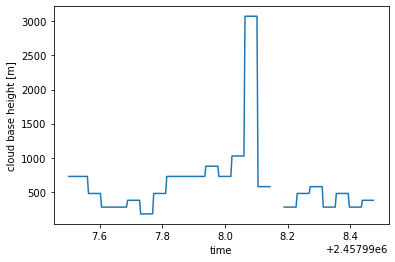

In [11]:
lidar.cbh.sel(column=0).plot()

In [15]:
from datetime import datetime, time, timedelta

times = []
ts = datetime(2017, 9, 1, 0, 0, 0)
while ts <= datetime(2017, 9, 2, 0, 0, 0):
    times.append(time(ts.hour, ts.minute, ts.second))
    ts += timedelta(minutes=5)

In [20]:
time_list = [(datetime(2017,9,1) + timedelta(minutes=i * 5)).strftime("%Y-%m-%d %H:%M:%S") for i in range(0,288)]
print(time_list)

['2017-09-01 00:00:00', '2017-09-01 00:05:00', '2017-09-01 00:10:00', '2017-09-01 00:15:00', '2017-09-01 00:20:00', '2017-09-01 00:25:00', '2017-09-01 00:30:00', '2017-09-01 00:35:00', '2017-09-01 00:40:00', '2017-09-01 00:45:00', '2017-09-01 00:50:00', '2017-09-01 00:55:00', '2017-09-01 01:00:00', '2017-09-01 01:05:00', '2017-09-01 01:10:00', '2017-09-01 01:15:00', '2017-09-01 01:20:00', '2017-09-01 01:25:00', '2017-09-01 01:30:00', '2017-09-01 01:35:00', '2017-09-01 01:40:00', '2017-09-01 01:45:00', '2017-09-01 01:50:00', '2017-09-01 01:55:00', '2017-09-01 02:00:00', '2017-09-01 02:05:00', '2017-09-01 02:10:00', '2017-09-01 02:15:00', '2017-09-01 02:20:00', '2017-09-01 02:25:00', '2017-09-01 02:30:00', '2017-09-01 02:35:00', '2017-09-01 02:40:00', '2017-09-01 02:45:00', '2017-09-01 02:50:00', '2017-09-01 02:55:00', '2017-09-01 03:00:00', '2017-09-01 03:05:00', '2017-09-01 03:10:00', '2017-09-01 03:15:00', '2017-09-01 03:20:00', '2017-09-01 03:25:00', '2017-09-01 03:30:00', '2017-09-0

In [21]:
pd.to_datetime(time_list)

DatetimeIndex(['2017-09-01 00:00:00', '2017-09-01 00:05:00',
               '2017-09-01 00:10:00', '2017-09-01 00:15:00',
               '2017-09-01 00:20:00', '2017-09-01 00:25:00',
               '2017-09-01 00:30:00', '2017-09-01 00:35:00',
               '2017-09-01 00:40:00', '2017-09-01 00:45:00',
               ...
               '2017-09-01 23:10:00', '2017-09-01 23:15:00',
               '2017-09-01 23:20:00', '2017-09-01 23:25:00',
               '2017-09-01 23:30:00', '2017-09-01 23:35:00',
               '2017-09-01 23:40:00', '2017-09-01 23:45:00',
               '2017-09-01 23:50:00', '2017-09-01 23:55:00'],
              dtype='datetime64[ns]', length=288, freq=None)

In [56]:
time_list = [(datetime(int('20' + str(12)),8,1) + timedelta(minutes=i * 5)).strftime("%Y-%m-%d %H:%M:%S") for i in range(0,288)]

In [57]:
time_list

['2012-08-01 00:00:00',
 '2012-08-01 00:05:00',
 '2012-08-01 00:10:00',
 '2012-08-01 00:15:00',
 '2012-08-01 00:20:00',
 '2012-08-01 00:25:00',
 '2012-08-01 00:30:00',
 '2012-08-01 00:35:00',
 '2012-08-01 00:40:00',
 '2012-08-01 00:45:00',
 '2012-08-01 00:50:00',
 '2012-08-01 00:55:00',
 '2012-08-01 01:00:00',
 '2012-08-01 01:05:00',
 '2012-08-01 01:10:00',
 '2012-08-01 01:15:00',
 '2012-08-01 01:20:00',
 '2012-08-01 01:25:00',
 '2012-08-01 01:30:00',
 '2012-08-01 01:35:00',
 '2012-08-01 01:40:00',
 '2012-08-01 01:45:00',
 '2012-08-01 01:50:00',
 '2012-08-01 01:55:00',
 '2012-08-01 02:00:00',
 '2012-08-01 02:05:00',
 '2012-08-01 02:10:00',
 '2012-08-01 02:15:00',
 '2012-08-01 02:20:00',
 '2012-08-01 02:25:00',
 '2012-08-01 02:30:00',
 '2012-08-01 02:35:00',
 '2012-08-01 02:40:00',
 '2012-08-01 02:45:00',
 '2012-08-01 02:50:00',
 '2012-08-01 02:55:00',
 '2012-08-01 03:00:00',
 '2012-08-01 03:05:00',
 '2012-08-01 03:10:00',
 '2012-08-01 03:15:00',
 '2012-08-01 03:20:00',
 '2012-08-01 03:

In [2]:
fdir = '/Users/peizhangcheng/Desktop/ALCF/MQI_Ceilometer/Macquarie Island (CL51)/processed/stats/all.nc'
cl51_stats = xr.open_dataset(fdir)

In [2]:
fdir = '/Users/peizhangcheng/Desktop/ALCF/MQI_Ceilometer/Macquarie Island (CL51)/processed_new/stats/all.nc'
cl51_stats = xr.open_dataset(fdir)

In [4]:
h = pd.Series(cl51_stats.zfull)
cl = pd.Series(cl51_stats.cl)

In [5]:
fdir = '/Users/peizhangcheng/Desktop/ALCF/MQI_Ceilometer/MI_neg/alcf_cl51_stats.nc'
cl51_stats_neg = xr.open_dataset(fdir)

In [39]:
fdir = '/Users/peizhangcheng/Desktop/ALCF/MQI_Ceilometer/MI_neg/processed_new/stats/all.nc'
cl51_stats_neg = xr.open_dataset(fdir)

In [42]:
h_neg = pd.Series(cl51_stats_neg.zfull)
cl_neg = pd.Series(cl51_stats_neg.cl)

In [43]:
fdir = '/Users/peizhangcheng/Desktop/ALCF/MQI_Ceilometer/MI_pos/processed_new/stats/all.nc'
cl51_stats_pos = xr.open_dataset(fdir)

In [45]:
h_pos = pd.Series(cl51_stats_pos.zfull)
cl_pos = pd.Series(cl51_stats_pos.cl)

In [46]:
fdir = '/Users/peizhangcheng/Desktop/ALCF/MQI_Ceilometer/MI_negLW/processed_new/stats/all.nc'
cl51_stats_negLW = xr.open_dataset(fdir)

In [47]:
h_negLW = pd.Series(cl51_stats_negLW.zfull)
cl_negLW = pd.Series(cl51_stats_negLW.cl)

In [49]:
fdir = '/Users/peizhangcheng/Desktop/ALCF/MQI_Ceilometer/MI_posLW/processed_new/stats/all.nc'
cl51_stats_posLW = xr.open_dataset(fdir)

In [50]:
h_posLW = pd.Series(cl51_stats_posLW.zfull)
cl_posLW = pd.Series(cl51_stats_posLW.cl)

In [7]:
fdir = '/Volumes/My Passport/ALCF/alcf-tutorial-datasets/ACCESS-AM2/processed/stats/all.nc'
access_stats = xr.open_dataset(fdir)

In [57]:
fdir = '/Volumes/My Passport/processed/stats/all.nc'
access_stats = xr.open_dataset(fdir)

In [58]:
h1 = pd.Series(access_stats.zfull)
cl1 = access_stats.cl.mean(dim='column')
tcl1 = access_stats.clt.mean(dim='column')

In [59]:
fdir = '/Volumes/My Passport/ALCF/alcf-tutorial-datasets/ACCESS_SWbias_neg/processed_new/stats/all.nc'
access_stats_neg = xr.open_dataset(fdir)

In [60]:
h1_neg = pd.Series(access_stats_neg.zfull)
cl1_neg = access_stats_neg.cl.mean(dim='column')
tcl1_neg = access_stats_neg.clt.mean(dim='column')

In [64]:
fdir = '/Volumes/My Passport/ALCF/alcf-tutorial-datasets/ACCESS_SWbias_pos/processed_new/stats/all.nc'
access_stats_pos = xr.open_dataset(fdir)

In [65]:
h1_pos = pd.Series(access_stats_pos.zfull)
cl1_pos = access_stats_pos.cl.mean(dim='column')
tcl1_pos = access_stats_pos.clt.mean(dim='column')

In [67]:
fdir = '/Volumes/My Passport/ALCF/alcf-tutorial-datasets/ACCESS_LWbias_neg/processed_new/stats/all.nc'
access_stats_negLW = xr.open_dataset(fdir)

In [68]:
h1_negLW = pd.Series(access_stats_negLW.zfull)
cl1_negLW = access_stats_negLW.cl.mean(dim='column')
tcl1_negLW = access_stats_negLW.clt.mean(dim='column')

In [69]:
fdir = '/Volumes/My Passport/ALCF/alcf-tutorial-datasets/ACCESS_LWbias_pos/processed_new/stats/all.nc'
access_stats_posLW = xr.open_dataset(fdir)

In [70]:
h1_posLW = pd.Series(access_stats_posLW.zfull)
cl1_posLW = access_stats_posLW.cl.mean(dim='column')
tcl1_posLW = access_stats_posLW.clt.mean(dim='column')

In [8]:
fdir = '/Volumes/My Passport/ALCF/alcf-tutorial-datasets/ACCESS_SWbias_neg/alcf_stats.nc'
access_stats_neg = xr.open_dataset(fdir)

In [72]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [10]:
names = locals()

In [42]:
h1 = pd.Series(access_stats.zfull)
cl1 = access_stats.cl.mean(dim='column')
tcl1 = access_stats.clt.mean(dim='column')
cl1_ste = access_stats.cl.std(dim='column')/np.sqrt(10)

cl1_neg = access_stats_neg.cl.mean(dim='column')
tcl1_neg = access_stats_neg.clt.mean(dim='column')
cl1_neg_ste = access_stats_neg.cl.std(dim='column')/np.sqrt(10)

cl1_pos = access_stats_pos.cl.mean(dim='column')
tcl1_pos = access_stats_pos.clt.mean(dim='column')
cl1_pos_ste = access_stats_pos.cl.std(dim='column')/np.sqrt(10)

cl1_negLW = access_stats_negLW.cl.mean(dim='column')
tcl1_negLW = access_stats_negLW.clt.mean(dim='column')
cl1_negLW_ste = access_stats_negLW.cl.std(dim='column')/np.sqrt(10)

cl1_posLW = access_stats_posLW.cl.mean(dim='column')
tcl1_posLW = access_stats_posLW.clt.mean(dim='column')
cl1_posLW_ste = access_stats_posLW.cl.std(dim='column')/np.sqrt(10)

#for i in np.arange(10):
#    names['cl'+str(i).rjust(2,'0')]=access_stats.cl.sel(column=i)
#    names['CF'+str(i).rjust(2,'0')]=access_stats.clt.sel(column=i)

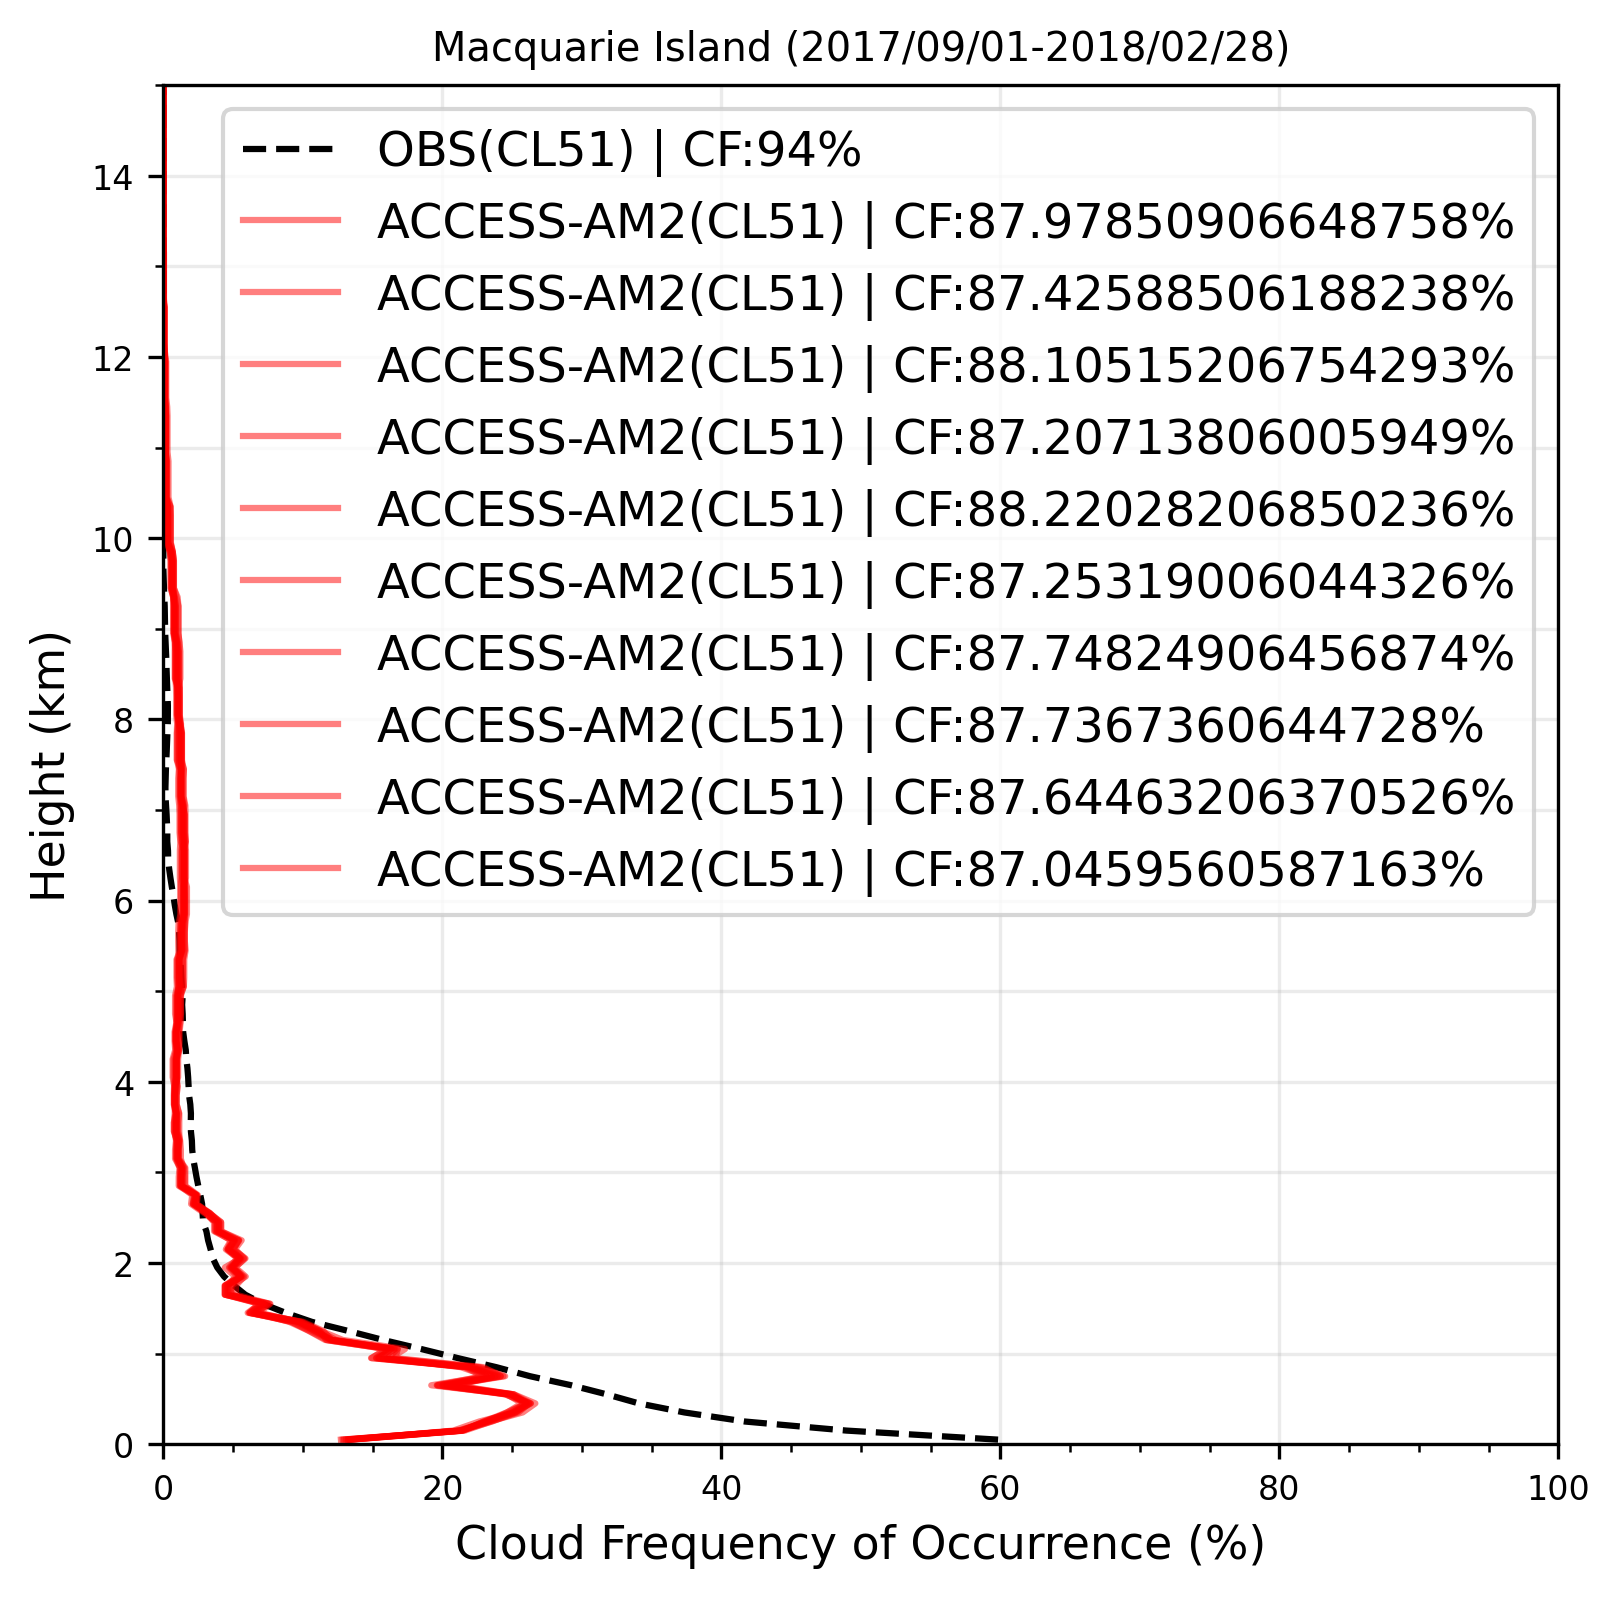

In [22]:
fig = plt.figure(figsize=(6,6),dpi=300)
plt.subplots_adjust(hspace=0.5)
plt.rcParams.update({'font.size': 8})

ax = plt.subplot()
plt.plot(cl, 1e-3*h, color='k', linewidth = 1.5, linestyle='--', label='OBS(CL51) | CF:94%');
for i in np.arange(10):
    plt.plot(names['cl'+str(i).rjust(2,'0')], 1e-3*h1, color='r', linewidth = 1.5, label='ACCESS-AM2(CL51) | CF:'+str(names['CF'+str(i).rjust(2,'0')].values)+'%',alpha=0.5);

plt.xlim(0., 100.);
plt.ylim(0., 15000*1e-3);
plt.xlabel('Cloud Frequency of Occurrence (%)',fontsize = 11);
plt.ylabel('Height (km)',fontsize = 11);
plt.legend(fontsize = 11.5);
plt.title('Macquarie Island (2017/09/01-2018/02/28)')

ax = plt.gca()
xmajorLocator = MultipleLocator(20)
xmajorFormatter = FormatStrFormatter('%1.1f')
xminorLocator = MultipleLocator(5) 
ymajorLocator = MultipleLocator(2)
ymajorFormatter = FormatStrFormatter('%1.1f')
yminorLocator = MultipleLocator(1) 

ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)

ax.xaxis.grid(True, which='major', alpha=0.25)
ax.yaxis.grid(True, which='major', alpha=0.25)
ax.yaxis.grid(True, which='minor', alpha=0.25)
          
#plt.savefig('/Users/peizhangcheng/Desktop/CFO_peter.jpg')
          
plt.show()

In [15]:
tcl1.values

array(87.63657296)

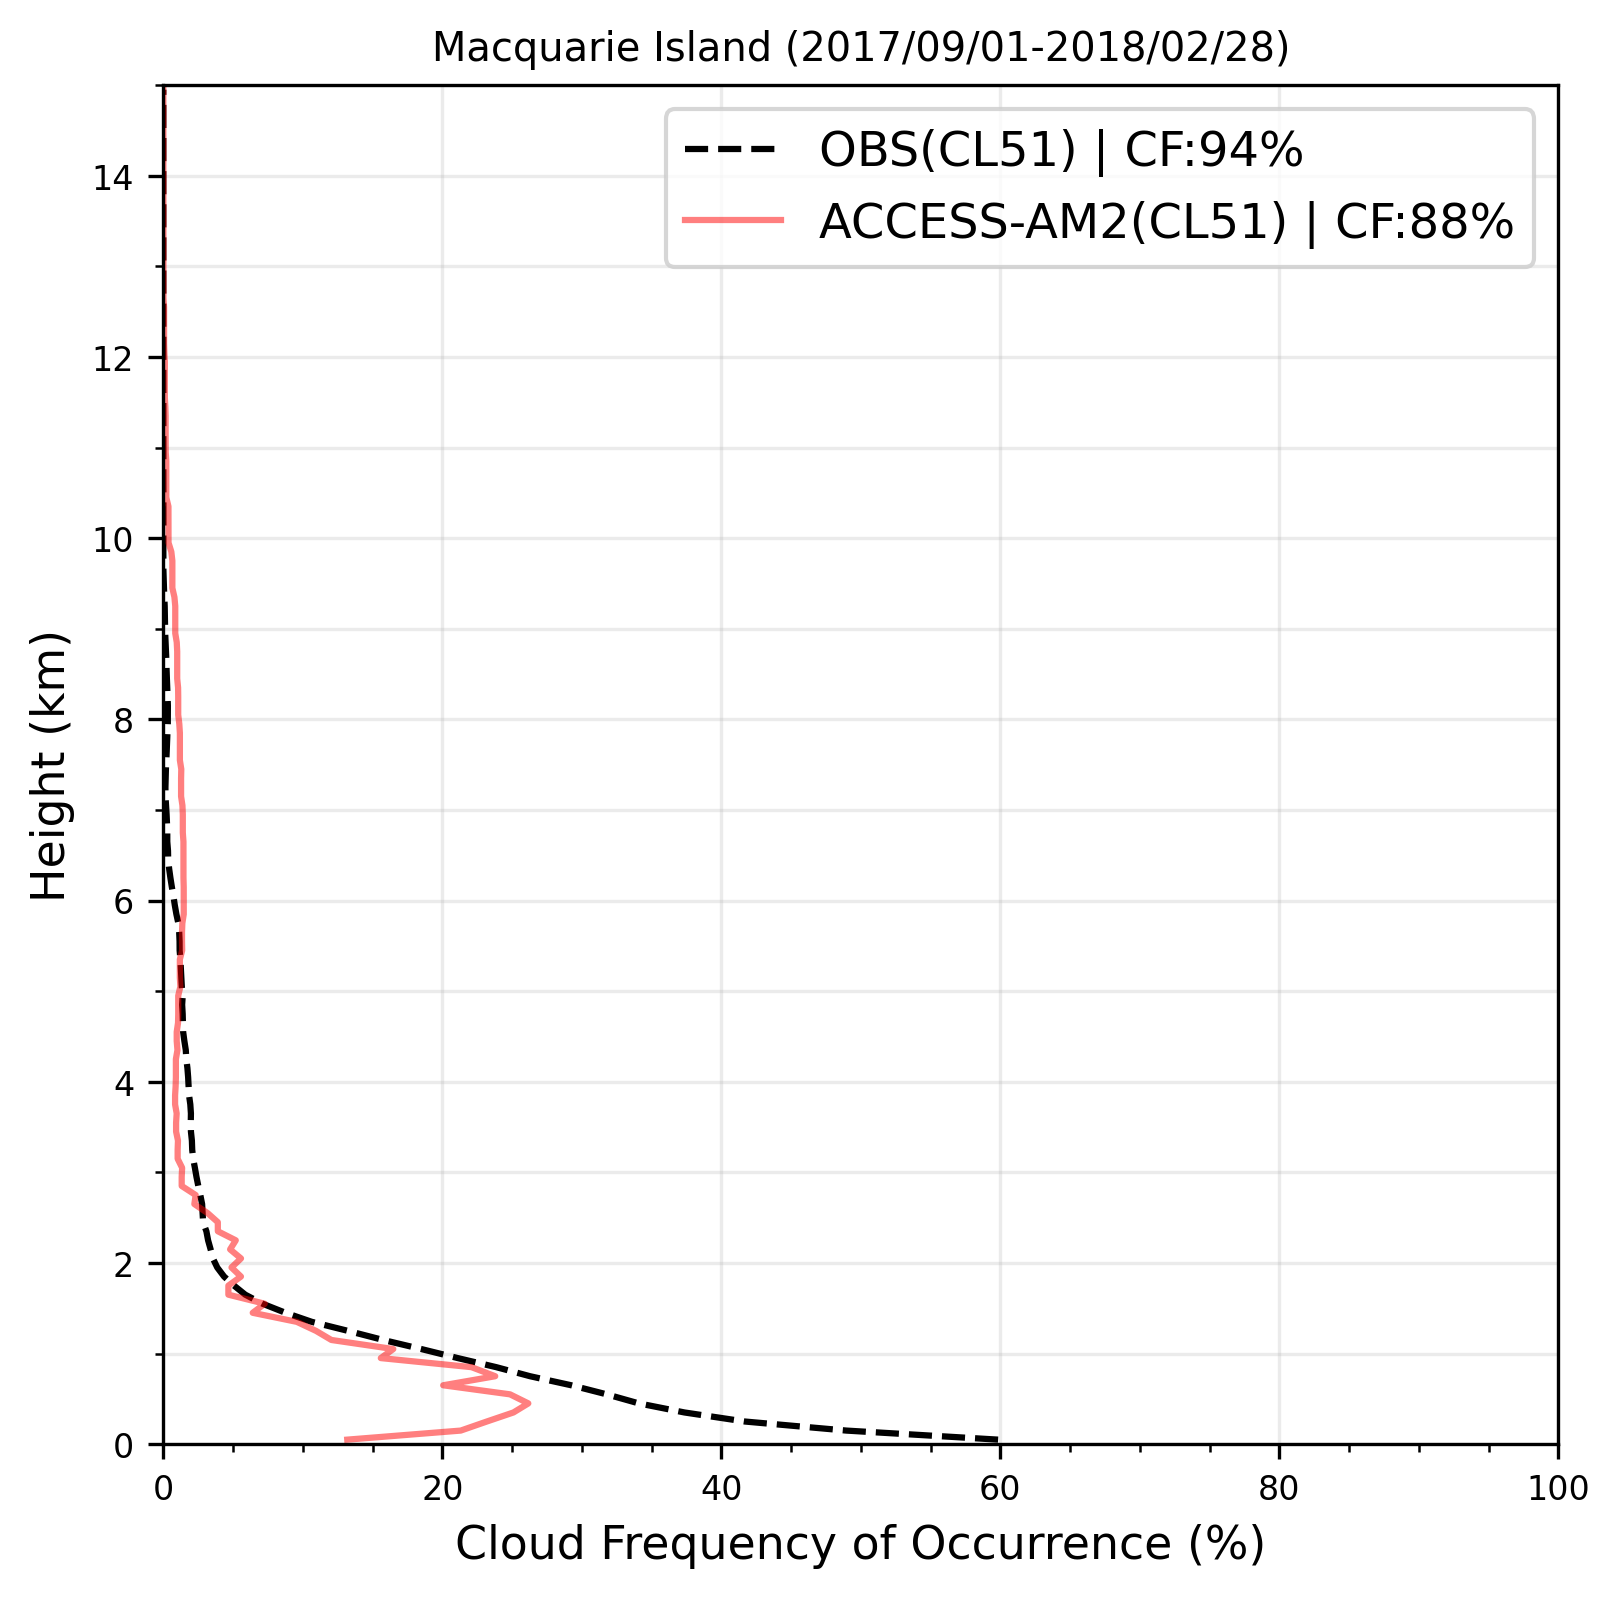

In [16]:
fig = plt.figure(figsize=(6,6),dpi=300)
plt.subplots_adjust(hspace=0.5)
plt.rcParams.update({'font.size': 8})

ax = plt.subplot()
plt.plot(cl, 1e-3*h, color='k', linewidth = 1.5, linestyle='--', label='OBS(CL51) | CF:94%');
plt.plot(cl1, 1e-3*h1, color='r', linewidth = 1.5, label='ACCESS-AM2(CL51) | CF:88%',alpha=0.5);

plt.xlim(0., 100.);
plt.ylim(0., 15000*1e-3);
plt.xlabel('Cloud Frequency of Occurrence (%)',fontsize = 11);
plt.ylabel('Height (km)',fontsize = 11);
plt.legend(fontsize = 11.5);
plt.title('Macquarie Island (2017/09/01-2018/02/28)')

ax = plt.gca()
xmajorLocator = MultipleLocator(20)
xmajorFormatter = FormatStrFormatter('%1.1f')
xminorLocator = MultipleLocator(5) 
ymajorLocator = MultipleLocator(2)
ymajorFormatter = FormatStrFormatter('%1.1f')
yminorLocator = MultipleLocator(1) 

ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)

ax.xaxis.grid(True, which='major', alpha=0.25)
ax.yaxis.grid(True, which='major', alpha=0.25)
ax.yaxis.grid(True, which='minor', alpha=0.25)
          
#plt.savefig('/Users/peizhangcheng/Desktop/CFO_peter.jpg')
          
plt.show()

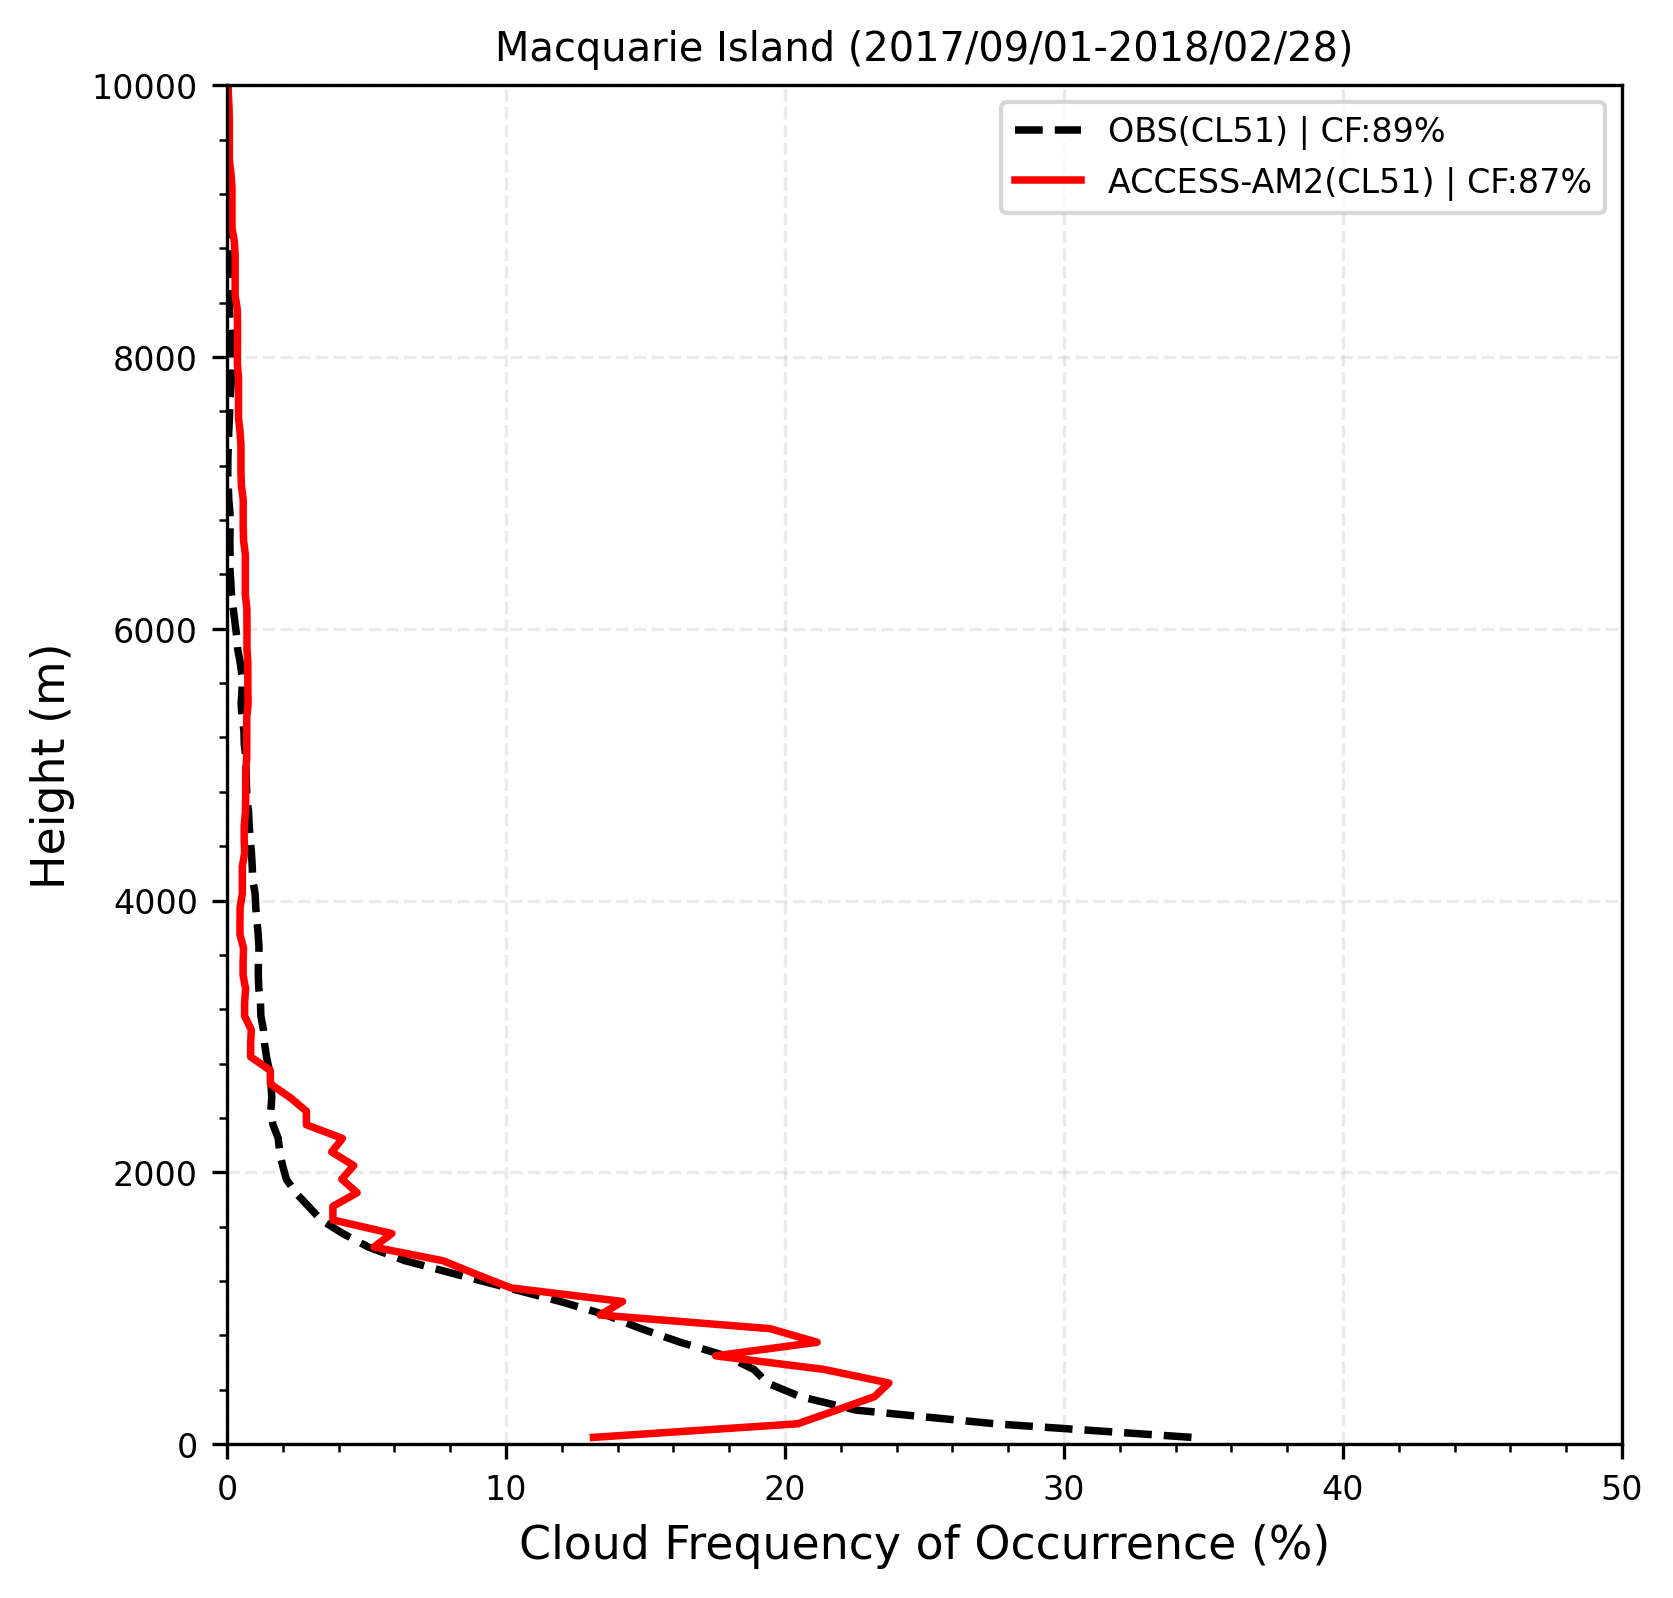

In [111]:
fig = plt.figure(figsize=(6,6),dpi=300)
plt.subplots_adjust(hspace=0.5)
plt.rcParams.update({'font.size': 8})

ax = plt.subplot()
plt.plot(cl, h, color='k', linewidth = 1.8, linestyle='--',label='OBS(CL51) | CF:89%');
plt.plot(cl1, h1, color='r', linewidth = 1.8, label='ACCESS-AM2(CL51) | CF:87%');
#ax.fill_betweenx(h1, cl1 - cl1_ste, cl1 + cl1_ste, alpha=0.2, color='r')

plt.xlim(0., 50.);
plt.ylim(0., 10000.);
plt.xlabel('Cloud Frequency of Occurrence (%)',fontsize = 11);
plt.ylabel('Height (m)',fontsize = 11);
plt.legend(fontsize = 8);
plt.title('Macquarie Island (2017/09/01-2018/02/28)')
#ax.set_yscale('log')

#ax = plt.gca()
#xmajorLocator = MultipleLocator(20)
#xmajorFormatter = FormatStrFormatter('%1.1f')
xminorLocator = MultipleLocator(2)
yminorLocator = MultipleLocator(400) 

#ymajorLocator = MultipleLocator(2)
#ymajorFormatter = FormatStrFormatter('%1.1f')
#yminorLocator = MultipleLocator(1) 

#ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
#ax.yaxis.set_major_locator(ymajorLocator)
#ax.yaxis.set_minor_locator(yminorLocator)

ax.xaxis.grid(True, which='major', alpha=0.25, linestyle='--')
ax.yaxis.grid(True, which='major', alpha=0.25, linestyle='--')
#ax.yaxis.grid(True, which='minor', alpha=0.25, linestyle='--')

#plt.savefig('/Users/peizhangcheng/Desktop/CFO_new.png')
plt.show()

In [45]:
h1_neg = pd.Series(access_stats_neg.zfull)

for i in np.arange(10):
    names['cl_neg'+str(i).rjust(2,'0')]=access_stats_neg.cl.sel(column=i)
    names['CF_neg'+str(i).rjust(2,'0')]=access_stats_neg.clt.sel(column=i)

In [79]:
cl51_stats_posLW

<xarray.Dataset>
Dimensions:              (backscatter_full: 39, backscatter_sd_full: 13, zfull: 150)
Coordinates:
  * zfull                (zfull) float64 50.0 150.0 ... 1.485e+04 1.495e+04
  * backscatter_full     (backscatter_full) float64 7.5e-06 ... 0.0001975
  * backscatter_sd_full  (backscatter_sd_full) float64 1.5e-09 ... 6.144e-06
Data variables:
    cl                   (zfull) float64 3.612 2.898 3.065 3.912 ... 0.0 0.0 0.0
    clt                  float64 ...
    n                    int64 ...
    backscatter_avg      (zfull) float64 ...
    backscatter_mol_avg  (zfull) float64 ...
    backscatter_hist     (backscatter_full, zfull) float64 ...
    backscatter_sd_hist  (backscatter_sd_full) float64 ...
    backscatter_sd_z     float64 ...

In [80]:
tcl1_posLW

<xarray.DataArray 'clt' ()>
array(92.40981595)

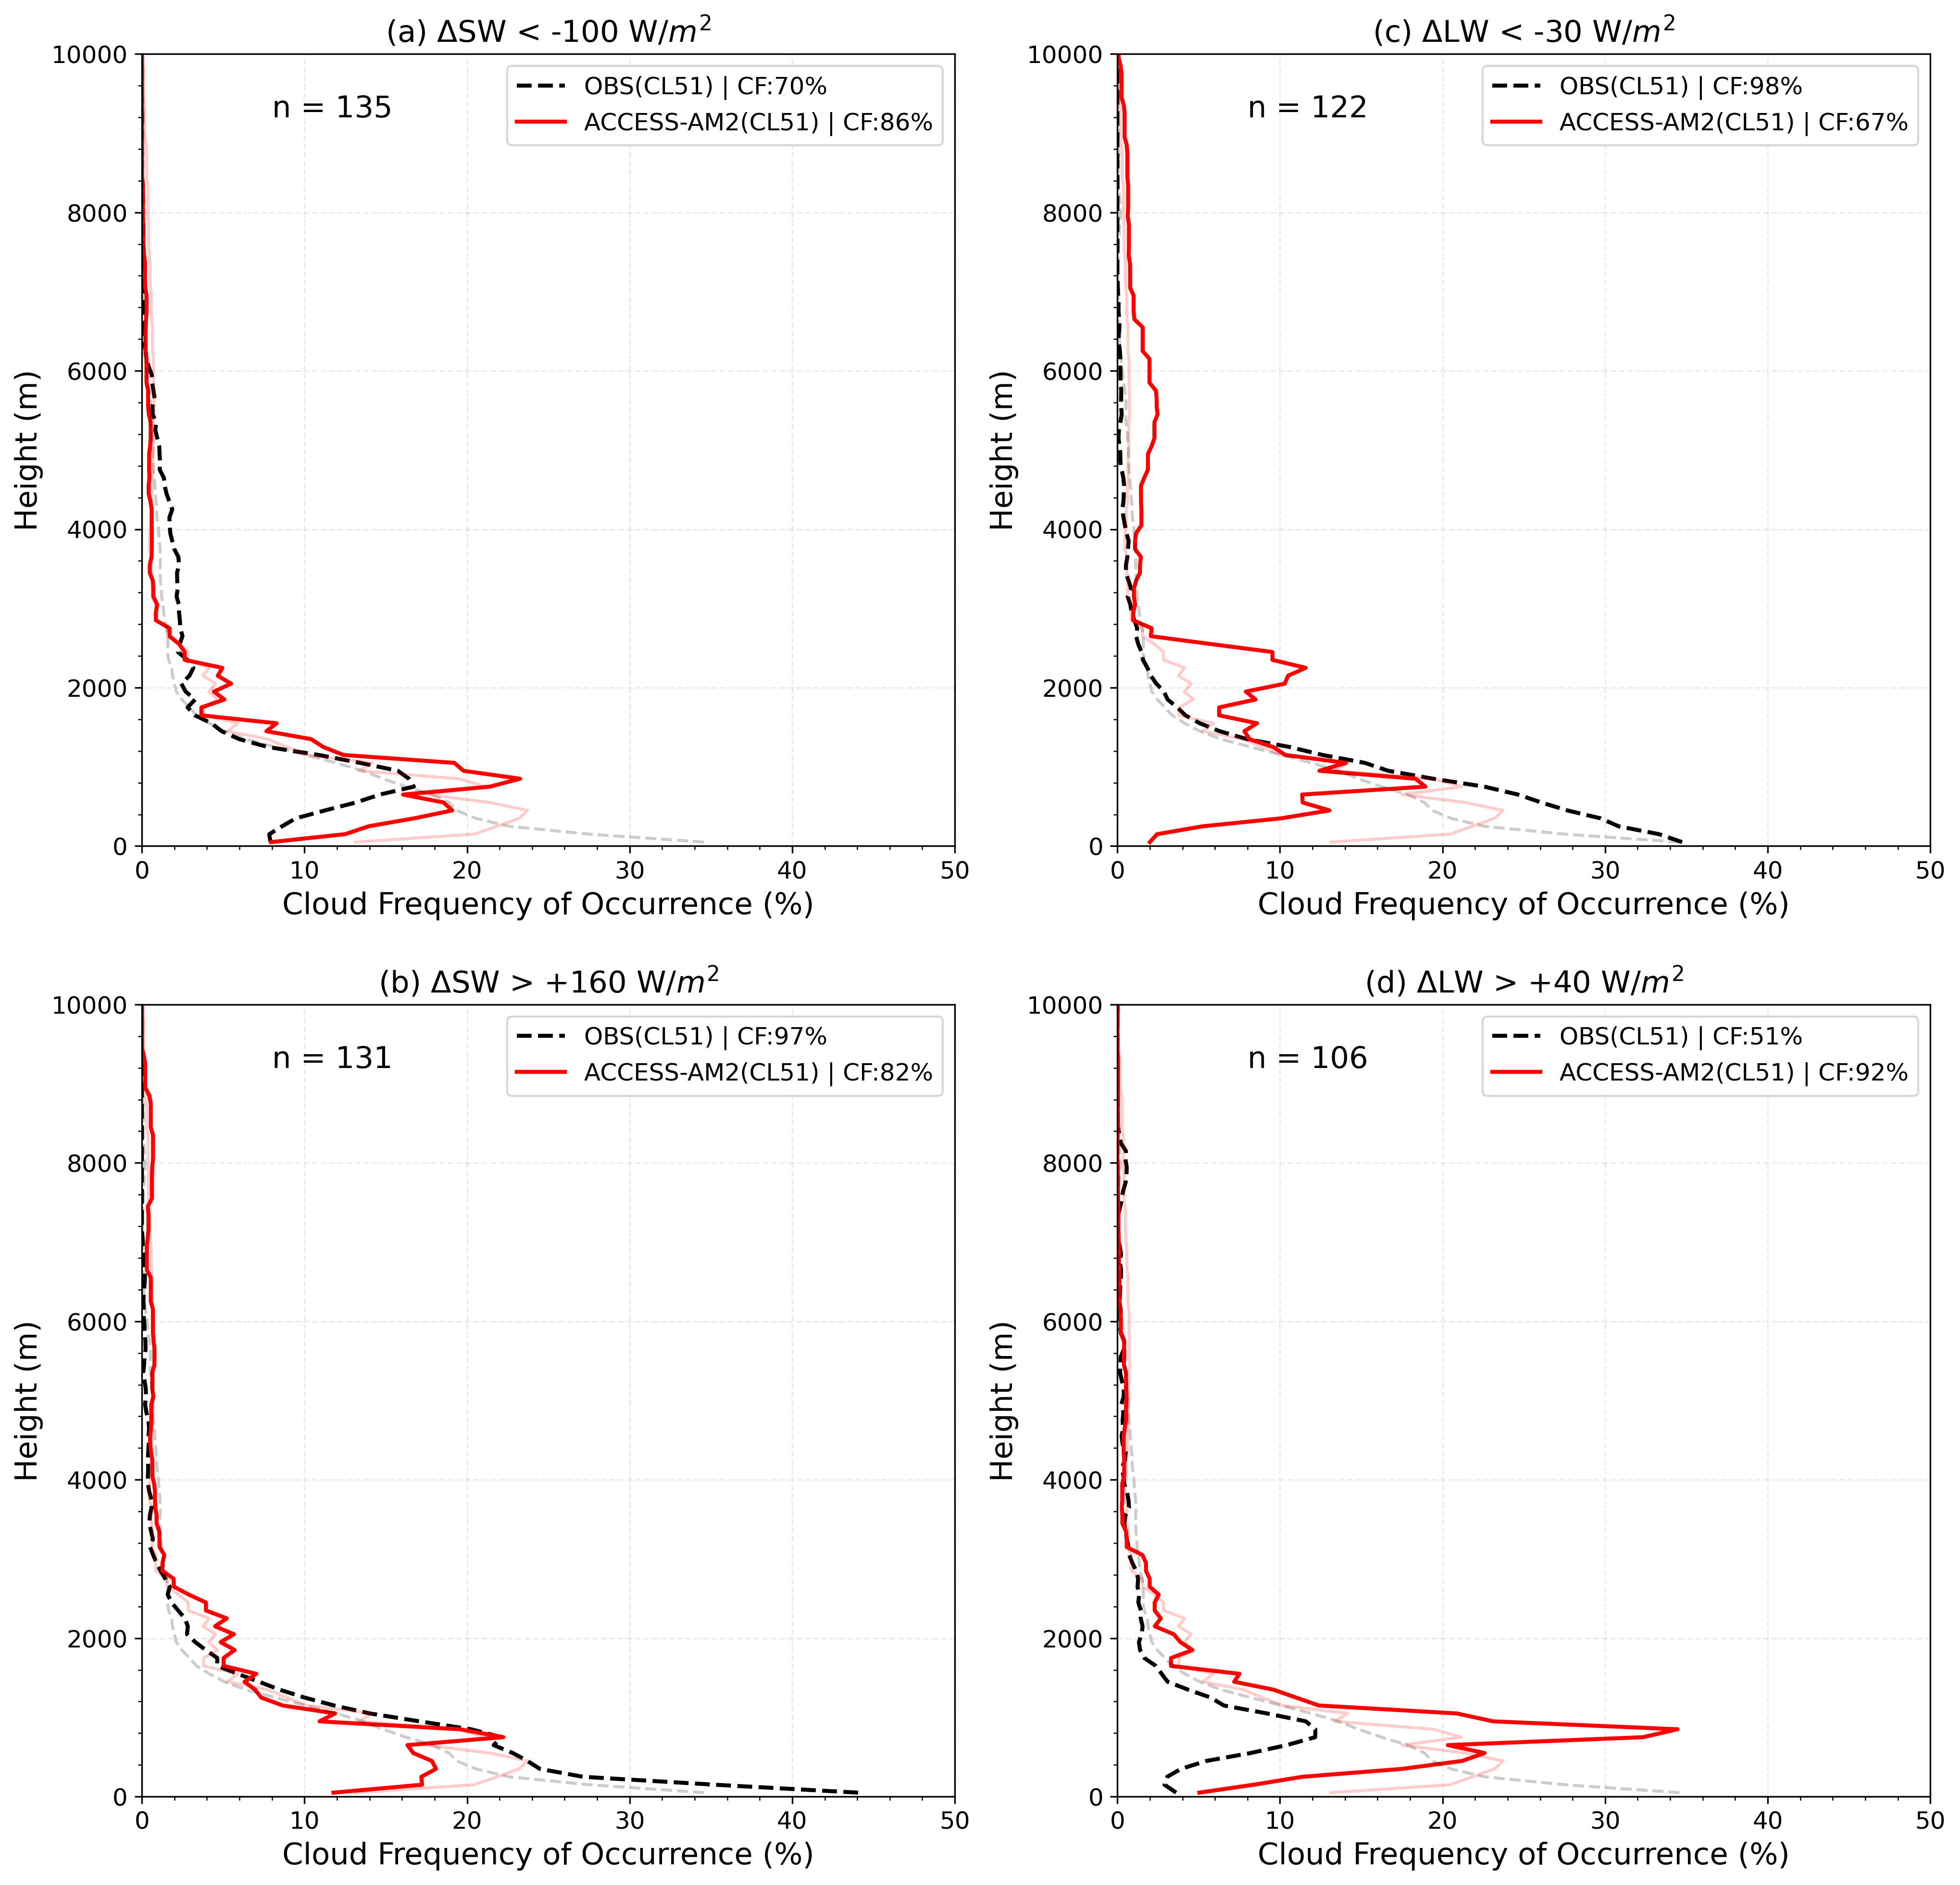

In [118]:
fig = plt.figure(figsize=(16,16),dpi=300)
plt.subplots_adjust(hspace=0.2)
plt.rcParams.update({'font.size': 8})

ax1 = plt.subplot(221)
plt.plot(cl_neg, h_neg, color='k', linewidth = 2, linestyle='--', label='OBS(CL51) | CF:70%'); # SW 135 LW 122
plt.plot(cl1_neg, h1_neg, color='r', linewidth = 2, label='ACCESS-AM2(CL51) | CF:86%'); # SW 131 LW 106
plt.plot(cl, h, color='k', linewidth = 1.5, linestyle='--', alpha=0.2);
plt.plot(cl1, h1, color='r', linewidth = 1.5, alpha=0.2);
#ax1.fill_betweenx(h1, cl1 - cl1_ste, cl1 + cl1_ste, alpha=0.2, color='r')
#ax1.fill_betweenx(h1, cl1_neg - cl1_neg_ste, cl1_neg + cl1_neg_ste, alpha=0.2, color='r')
plt.annotate('n = 135',(8,9200),fontsize = 15)
plt.xlim(0., 50.);
plt.ylim(0., 10000.);
plt.xlabel('Cloud Frequency of Occurrence (%)',fontsize = 15);
plt.ylabel('Height (m)',fontsize = 15);
plt.xticks(size = 12);
plt.yticks(size = 12);
plt.legend(fontsize = 12);
plt.title('(a) $\Delta$SW < -100 W/$m^{2}$', fontsize =15)
#ax1.set_yscale('log')

ax = plt.gca()
#xmajorLocator = MultipleLocator(20)
#xmajorFormatter = FormatStrFormatter('%1.1f')
xminorLocator = MultipleLocator(2) 
#ymajorLocator = MultipleLocator(2)
#ymajorFormatter = FormatStrFormatter('%1.1f')
yminorLocator = MultipleLocator(400) 

#ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
#ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)

ax.xaxis.grid(True, which='major', alpha=0.25, linestyle='--')
ax.yaxis.grid(True, which='major', alpha=0.25, linestyle='--')
#ax.yaxis.grid(True, which='minor', alpha=0.25, linestyle='--')

ax2 = plt.subplot(223,)
plt.plot(cl_pos, h_pos, color='k', linewidth = 2, linestyle='--', label='OBS(CL51) | CF:97%');
plt.plot(cl1_pos, h1_pos, color='r', linewidth = 2, label='ACCESS-AM2(CL51) | CF:82%');
plt.plot(cl, h, color='k', linewidth = 1.5, linestyle='--', alpha=0.2);
plt.plot(cl1, h1, color='r', linewidth = 1.5, alpha=0.2);
#ax2.fill_betweenx(h1, cl1 - cl1_ste, cl1 + cl1_ste, alpha=0.2, color='r')
#ax2.fill_betweenx(h1, cl1_pos - cl1_pos_ste, cl1_pos + cl1_pos_ste, alpha=0.2, color='r')
plt.annotate('n = 131',(8,9200),fontsize = 15)
plt.xlim(0., 50.);
plt.ylim(0., 10000.);
plt.xlabel('Cloud Frequency of Occurrence (%)',fontsize = 15);
plt.ylabel('Height (m)',fontsize = 15);
plt.xticks(size = 12);
plt.yticks(size = 12);
plt.legend(fontsize = 12);
plt.title('(b) $\Delta$SW > +160 W/$m^{2}$', fontsize =15)
#ax2.set_yscale('log')

ax = plt.gca()
#xmajorLocator = MultipleLocator(20)
#xmajorFormatter = FormatStrFormatter('%1.1f')
xminorLocator = MultipleLocator(2) 
#ymajorLocator = MultipleLocator(2)
#ymajorFormatter = FormatStrFormatter('%1.1f')
yminorLocator = MultipleLocator(400) 

#ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
#ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)

ax.xaxis.grid(True, which='major', alpha=0.25, linestyle='--')
ax.yaxis.grid(True, which='major', alpha=0.25, linestyle='--')
#ax.yaxis.grid(True, which='minor', alpha=0.25, linestyle='--')

ax3 = plt.subplot(222,)
plt.plot(cl_negLW, h_negLW, color='k', linewidth = 2, linestyle='--', label='OBS(CL51) | CF:98%');
plt.plot(cl1_negLW, h1_negLW, color='r', linewidth = 2, label='ACCESS-AM2(CL51) | CF:67%');
plt.plot(cl, h, color='k', linewidth = 1.5, linestyle='--', alpha=0.2);
plt.plot(cl1, h1, color='r', linewidth = 1.5, alpha=0.2);
#ax3.fill_betweenx(h1, cl1 - cl1_ste, cl1 + cl1_ste, alpha=0.2, color='r')
#ax3.fill_betweenx(h1, cl1_negLW - cl1_negLW_ste, cl1_negLW + cl1_negLW_ste, alpha=0.2, color='r')
plt.annotate('n = 122',(8,9200),fontsize = 15)
plt.xlim(0., 50.);
plt.ylim(0., 10000.);
plt.xlabel('Cloud Frequency of Occurrence (%)',fontsize = 15);
plt.ylabel('Height (m)',fontsize = 15);
plt.xticks(size = 12);
plt.yticks(size = 12);
plt.legend(fontsize = 12);
plt.title('(c) $\Delta$LW < -30 W/$m^{2}$', fontsize =15)
#ax3.set_yscale('log')

ax = plt.gca()
#xmajorLocator = MultipleLocator(20)
#xmajorFormatter = FormatStrFormatter('%1.1f')
xminorLocator = MultipleLocator(2) 
#ymajorLocator = MultipleLocator(2)
#ymajorFormatter = FormatStrFormatter('%1.1f')
yminorLocator = MultipleLocator(400) 

#ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
#ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)

ax.xaxis.grid(True, which='major', alpha=0.25, linestyle='--')
ax.yaxis.grid(True, which='major', alpha=0.25, linestyle='--')
#ax.yaxis.grid(True, which='minor', alpha=0.25, linestyle='--')

ax4 = plt.subplot(224,)
plt.plot(cl_posLW, h_posLW, color='k', linewidth = 2, linestyle='--', label='OBS(CL51) | CF:51%');
plt.plot(cl1_posLW, h1_posLW, color='r', linewidth = 2, label='ACCESS-AM2(CL51) | CF:92%');
plt.plot(cl, h, color='k', linewidth = 1.5, linestyle='--', alpha=0.2);
plt.plot(cl1, h1, color='r', linewidth = 1.5, alpha=0.2);
#ax4.fill_betweenx(h1, cl1 - cl1_ste, cl1 + cl1_ste, alpha=0.2, color='r')
#ax4.fill_betweenx(h1, cl1_posLW - cl1_posLW_ste, cl1_posLW + cl1_posLW_ste, alpha=0.2, color='r')
plt.annotate('n = 106',(8,9200),fontsize = 15)
plt.xlim(0., 50.);
plt.ylim(0., 10000.);
plt.xlabel('Cloud Frequency of Occurrence (%)',fontsize = 15);
plt.ylabel('Height (m)',fontsize = 15);
plt.xticks(size = 12);
plt.yticks(size = 12);
plt.legend(fontsize = 12);
plt.title('(d) $\Delta$LW > +40 W/$m^{2}$', fontsize =15)
#ax4.set_yscale('log')

ax = plt.gca()
#xmajorLocator = MultipleLocator(20)
#xmajorFormatter = FormatStrFormatter('%1.1f')
xminorLocator = MultipleLocator(2) 
yminorLocator = MultipleLocator(400)
#ymajorFormatter = FormatStrFormatter('%1.1f')
#yminorLocator = MultipleLocator(1) 

#ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
#ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)

ax.xaxis.grid(True, which='major', alpha=0.25, linestyle='--')
ax.yaxis.grid(True, which='major', alpha=0.25, linestyle='--')
#ax.yaxis.grid(True, which='minor', alpha=0.25, linestyle='--')

#plt.savefig('/Users/peizhangcheng/Desktop/CFO_bias_new_nolog.png')

plt.show()

In [11]:
fdir = '/Users/peizhangcheng/Desktop/ALCF/MQI_Ceilometer/MI_pos/alcf_cl51_stats.nc'
cl51_stats_pos = xr.open_dataset(fdir)

In [13]:
fdir = '/Volumes/My Passport/ALCF/alcf-tutorial-datasets/ACCESS_SWbias_pos/alcf_access_stats.nc'
access_stats_pos = xr.open_dataset(fdir)

In [14]:
h_pos = pd.Series(cl51_stats_pos.zfull)
cl_pos = pd.Series(cl51_stats_pos.cl)

In [49]:
h1_pos = pd.Series(access_stats_pos.zfull)

for i in np.arange(10):
    names['cl_pos'+str(i).rjust(2,'0')]=access_stats_pos.cl.sel(column=i)
    names['CF_pos'+str(i).rjust(2,'0')]=access_stats_pos.clt.sel(column=i)
    
    names['cl_negLW'+str(i).rjust(2,'0')]=access_stats_negLW.cl.sel(column=i)
    names['CF_negLW'+str(i).rjust(2,'0')]=access_stats_negLW.clt.sel(column=i)
    
    names['cl_posLW'+str(i).rjust(2,'0')]=access_stats_posLW.cl.sel(column=i)
    names['CF_posLW'+str(i).rjust(2,'0')]=access_stats_posLW.clt.sel(column=i)

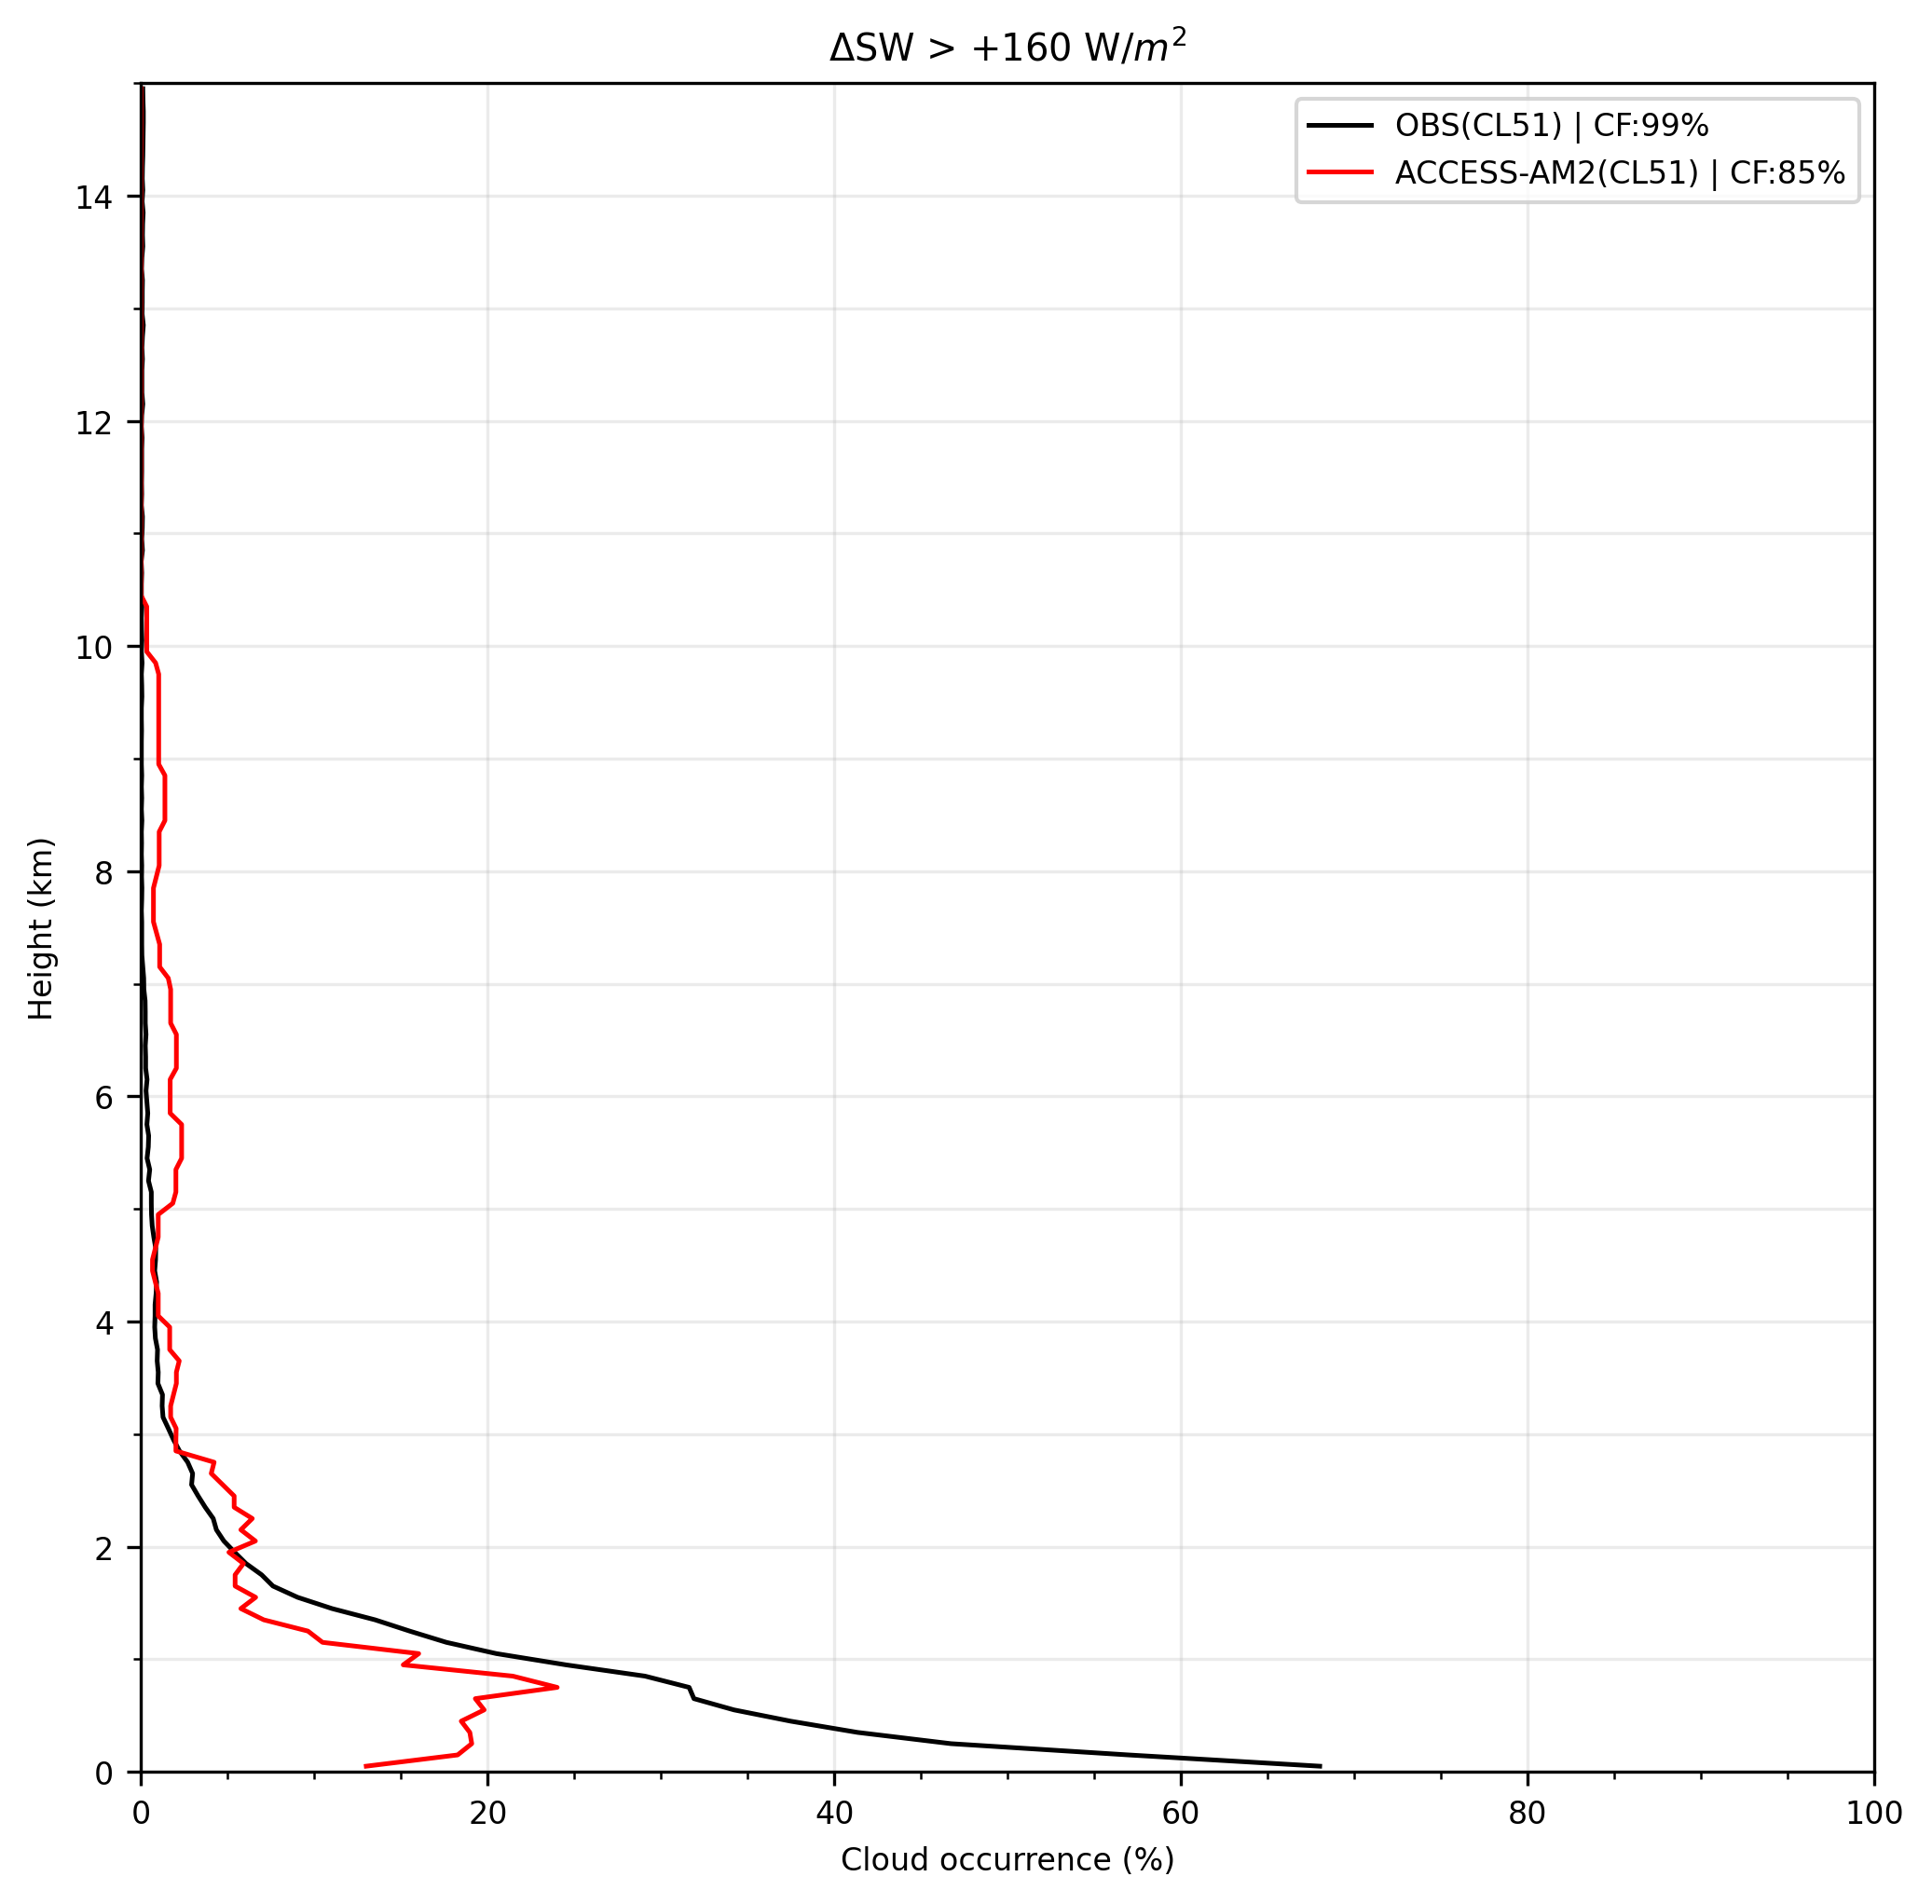

In [41]:
fig = plt.figure(figsize=(8,8),dpi=300)
plt.subplots_adjust(hspace=0.5)
plt.rcParams.update({'font.size': 8})

ax1 = plt.subplot()
plt.plot(cl_pos, 1e-3*h_pos, color='k', linewidth = 1.2, label='OBS(CL51) | CF:99%');
plt.plot(cl1_pos, 1e-3*h1_pos, color='r', linewidth = 1.2, label='ACCESS-AM2(CL51) | CF:85%');
plt.xlim(0., 100.);
plt.ylim(0., 15000*1e-3);
plt.xlabel('Cloud occurrence (%)');
plt.ylabel('Height (km)');
plt.legend();
plt.title('$\Delta$SW > +160 W/$m^{2}$')

ax = plt.gca()
xmajorLocator = MultipleLocator(20)
xmajorFormatter = FormatStrFormatter('%1.1f')
xminorLocator = MultipleLocator(5) 
ymajorLocator = MultipleLocator(2)
ymajorFormatter = FormatStrFormatter('%1.1f')
yminorLocator = MultipleLocator(1) 

ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)

ax.xaxis.grid(True, which='major', alpha=0.25)
ax.yaxis.grid(True, which='major', alpha=0.25)
ax.yaxis.grid(True, which='minor', alpha=0.25)

plt.show()

In [42]:
fdir = '/Users/peizhangcheng/Desktop/ALCF/MQI_Ceilometer/MI_med/alcf_cl51_stats.nc'
cl51_stats_med = xr.open_dataset(fdir)

In [43]:
cl51_stats_med

<xarray.Dataset>
Dimensions:              (backscatter_full: 39, backscatter_sd_full: 13, zfull: 150)
Coordinates:
  * zfull                (zfull) float64 50.0 150.0 ... 1.485e+04 1.495e+04
  * backscatter_full     (backscatter_full) float64 7.5e-06 ... 0.0001975
  * backscatter_sd_full  (backscatter_sd_full) float64 1.5e-09 ... 6.144e-06
Data variables:
    cl                   (zfull) float64 ...
    clt                  float64 ...
    n                    int64 ...
    backscatter_avg      (zfull) float64 ...
    backscatter_mol_avg  (zfull) float64 ...
    backscatter_hist     (backscatter_full, zfull) float64 ...
    backscatter_sd_hist  (backscatter_sd_full) float64 ...
    backscatter_sd_z     float64 ...

In [44]:
fdir = '/Volumes/My Passport/ALCF/alcf-tutorial-datasets/ACCESS_SWbias_med/alcf_stats.nc'
access_stats_med = xr.open_dataset(fdir)

In [45]:
access_stats_med

<xarray.Dataset>
Dimensions:              (backscatter_full: 39, backscatter_sd_full: 13, column: 10, zfull: 150)
Coordinates:
  * zfull                (zfull) float64 50.0 150.0 ... 1.485e+04 1.495e+04
  * backscatter_full     (backscatter_full) float64 7.5e-06 ... 0.0001975
  * backscatter_sd_full  (backscatter_sd_full) float64 1.5e-09 ... 6.144e-06
Dimensions without coordinates: column
Data variables:
    cl                   (zfull, column) float64 ...
    clt                  (column) float64 ...
    n                    (column) int64 ...
    backscatter_avg      (zfull, column) float64 ...
    backscatter_mol_avg  (zfull, column) float64 ...
    backscatter_hist     (backscatter_full, zfull, column) float64 ...
    backscatter_sd_hist  (backscatter_sd_full, column) float64 ...
    backscatter_sd_z     float64 ...

In [46]:
h_med = pd.Series(cl51_stats_med.zfull)
cl_med = pd.Series(cl51_stats_med.cl)

In [47]:
h1_med = pd.Series(access_stats_med.zfull)
cl1_med = access_stats_med.cl.sel(column=0)

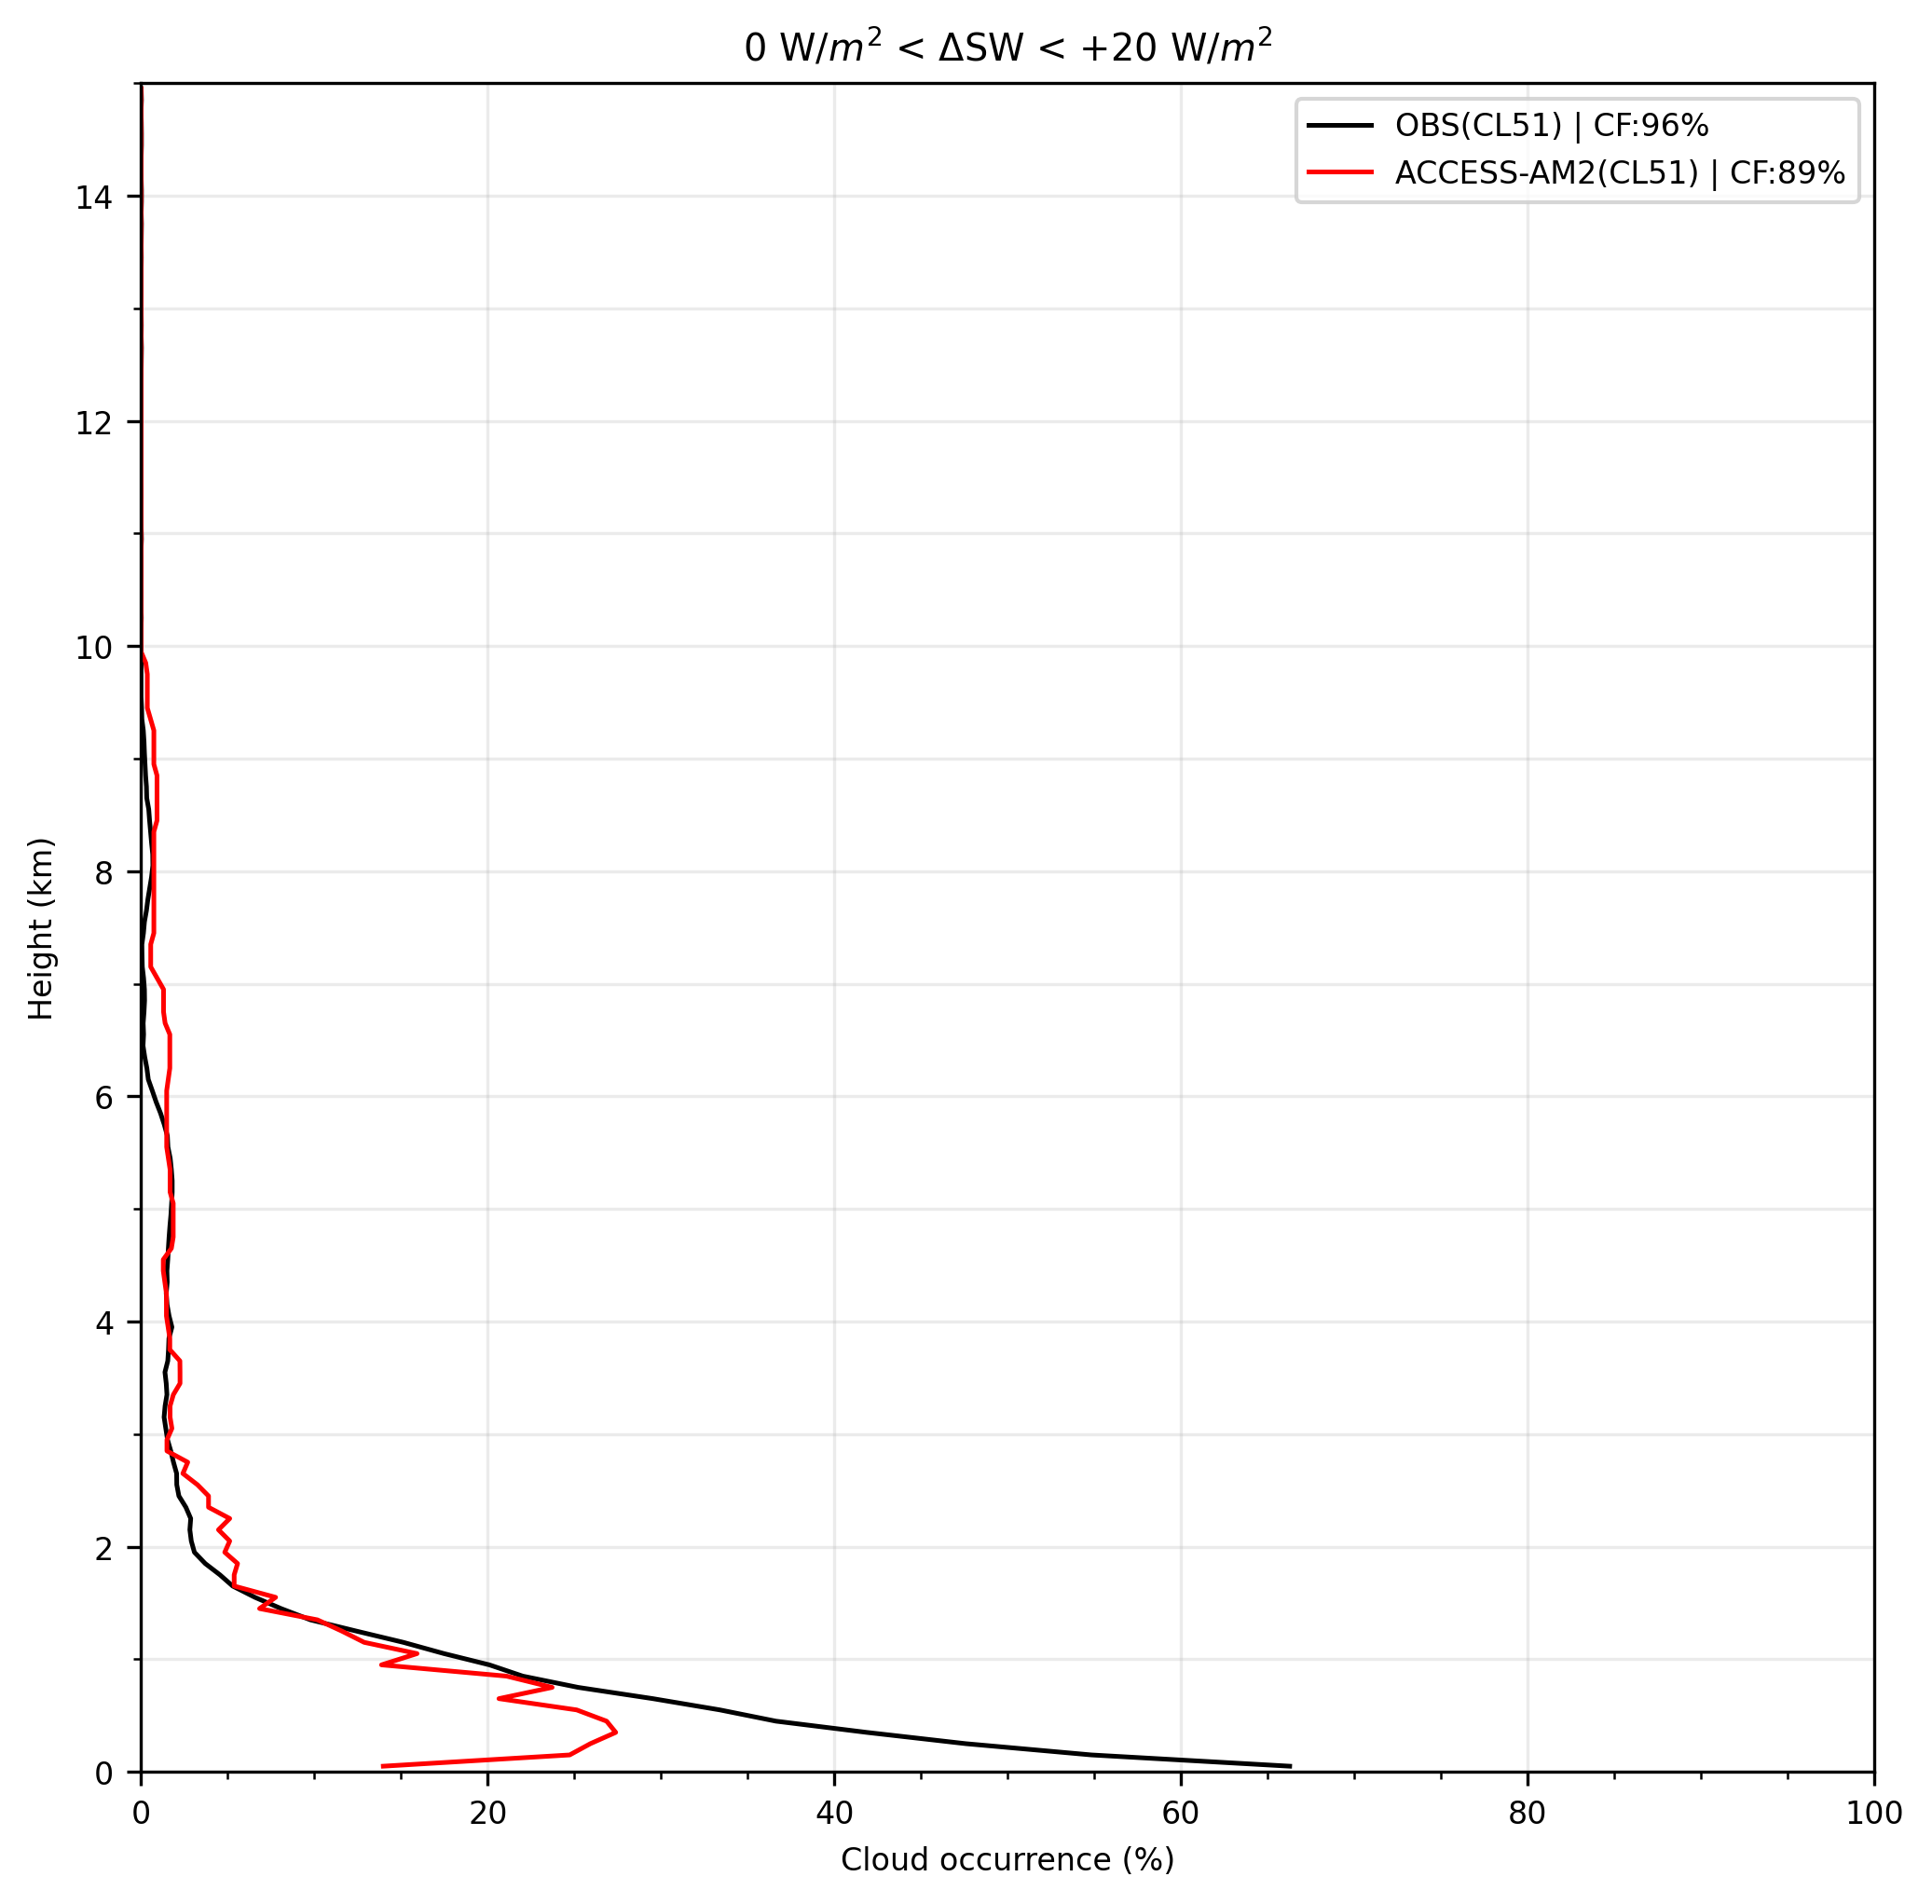

In [48]:
fig = plt.figure(figsize=(8,8),dpi=300)
plt.subplots_adjust(hspace=0.5)
plt.rcParams.update({'font.size': 8})

ax1 = plt.subplot()
plt.plot(cl_med, 1e-3*h_med, color='k', linewidth = 1.2, label='OBS(CL51) | CF:96%');
plt.plot(cl1_med, 1e-3*h1_med, color='r', linewidth = 1.2, label='ACCESS-AM2(CL51) | CF:89%');
plt.xlim(0., 100.);
plt.ylim(0., 15000*1e-3);
plt.xlabel('Cloud occurrence (%)');
plt.ylabel('Height (km)');
plt.legend();
plt.title('0 W/$m^{2}$ < $\Delta$SW < +20 W/$m^{2}$')

ax = plt.gca()
xmajorLocator = MultipleLocator(20)
xmajorFormatter = FormatStrFormatter('%1.1f')
xminorLocator = MultipleLocator(5) 
ymajorLocator = MultipleLocator(2)
ymajorFormatter = FormatStrFormatter('%1.1f')
yminorLocator = MultipleLocator(1) 

ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)

ax.xaxis.grid(True, which='major', alpha=0.25)
ax.yaxis.grid(True, which='major', alpha=0.25)
ax.yaxis.grid(True, which='minor', alpha=0.25)

plt.show()

In [15]:
fdir = '/Users/peizhangcheng/Desktop/ALCF/MQI_Ceilometer/MI_negLW/alcf_cl51_stats.nc'
cl51_stats_negLW = xr.open_dataset(fdir)

In [16]:
fdir = '/Volumes/My Passport/ALCF/alcf-tutorial-datasets/ACCESS_LWbias_neg/alcf_stats.nc'
access_stats_negLW = xr.open_dataset(fdir)

In [17]:
h_negLW = pd.Series(cl51_stats_negLW.zfull)
cl_negLW = pd.Series(cl51_stats_negLW.cl)

In [18]:
h1_negLW = pd.Series(access_stats_negLW.zfull)
cl1_negLW = access_stats_negLW.cl.sel(column=0)

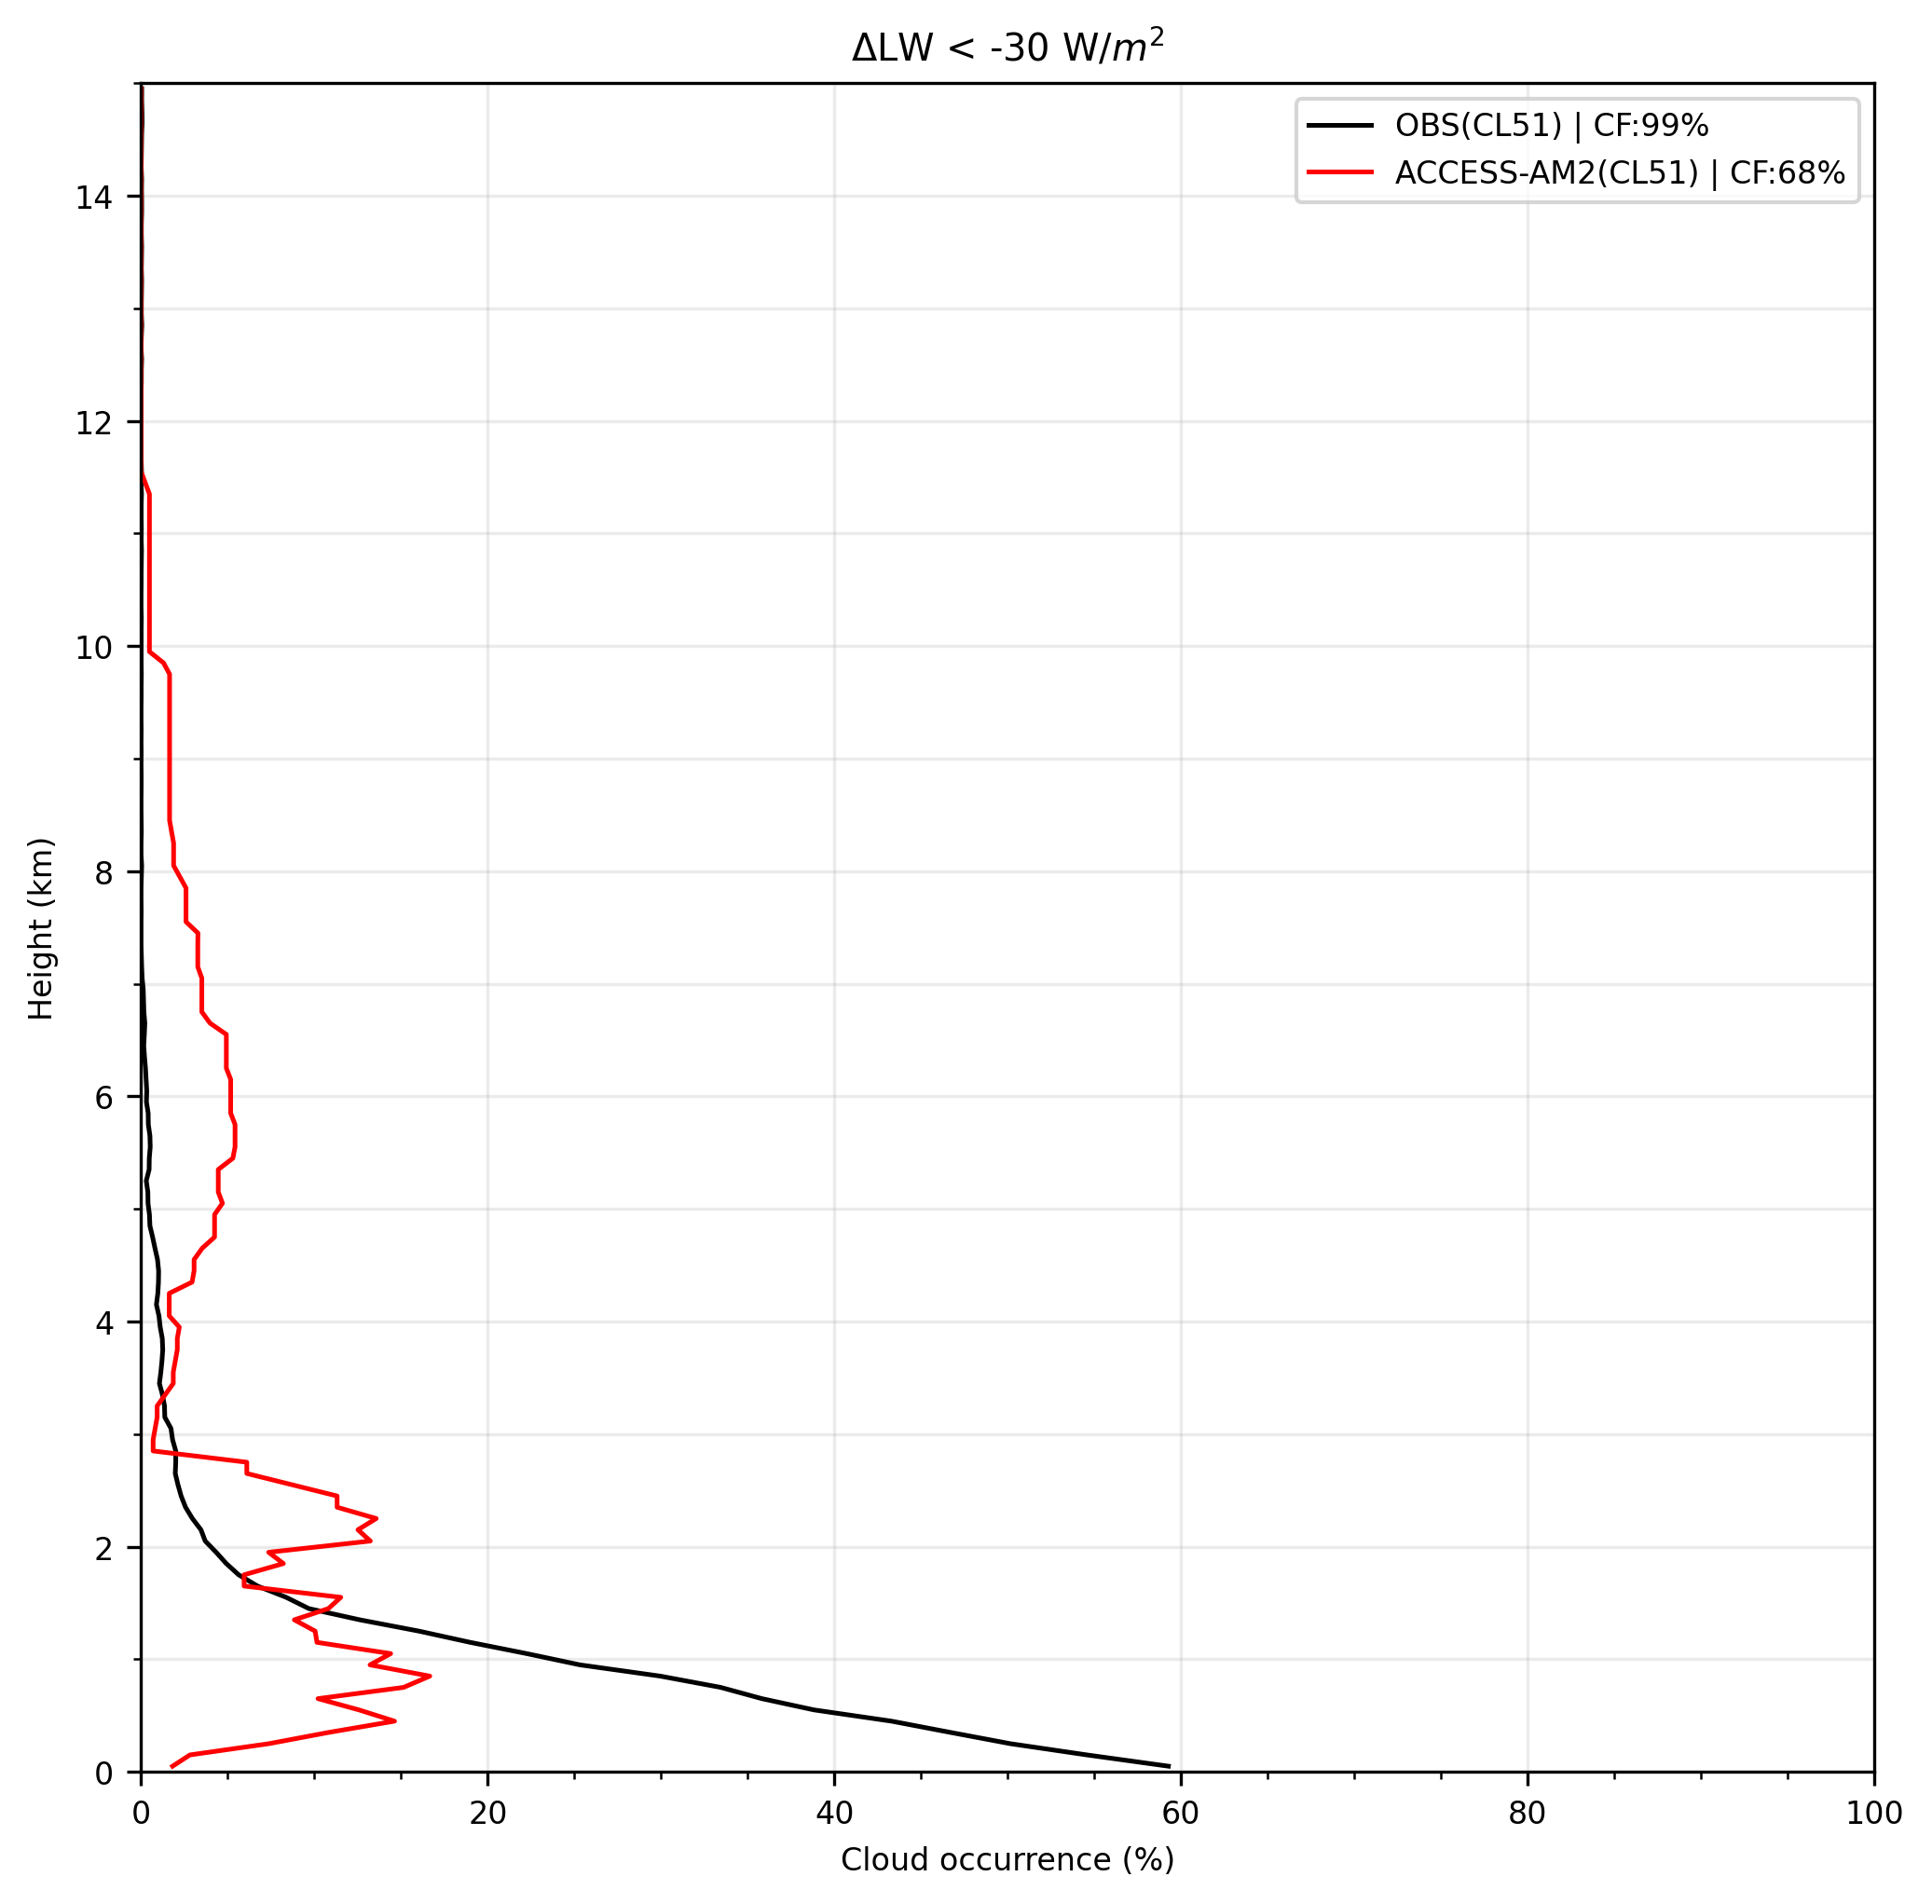

In [55]:
fig = plt.figure(figsize=(8,8),dpi=300)
plt.subplots_adjust(hspace=0.5)
plt.rcParams.update({'font.size': 8})

ax1 = plt.subplot()
plt.plot(cl_negLW, 1e-3*h_negLW, color='k', linewidth = 1.2, label='OBS(CL51) | CF:99%');
plt.plot(cl1_negLW, 1e-3*h1_negLW, color='r', linewidth = 1.2, label='ACCESS-AM2(CL51) | CF:68%');
plt.xlim(0., 100.);
plt.ylim(0., 15000*1e-3);
plt.xlabel('Cloud occurrence (%)');
plt.ylabel('Height (km)');
plt.legend();
plt.title('$\Delta$LW < -30 W/$m^{2}$')

ax = plt.gca()
xmajorLocator = MultipleLocator(20)
xmajorFormatter = FormatStrFormatter('%1.1f')
xminorLocator = MultipleLocator(5) 
ymajorLocator = MultipleLocator(2)
ymajorFormatter = FormatStrFormatter('%1.1f')
yminorLocator = MultipleLocator(1) 

ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)

ax.xaxis.grid(True, which='major', alpha=0.25)
ax.yaxis.grid(True, which='major', alpha=0.25)
ax.yaxis.grid(True, which='minor', alpha=0.25)

plt.show()

In [19]:
fdir = '/Users/peizhangcheng/Desktop/ALCF/MQI_Ceilometer/MI_posLW/alcf_cl51_stats.nc'
cl51_stats_posLW = xr.open_dataset(fdir)

In [20]:
fdir = '/Volumes/My Passport/ALCF/alcf-tutorial-datasets/ACCESS_LWbias_pos/alcf_stats.nc'
access_stats_posLW = xr.open_dataset(fdir)

In [21]:
h_posLW = pd.Series(cl51_stats_posLW.zfull)
cl_posLW = pd.Series(cl51_stats_posLW.cl)

In [22]:
h1_posLW = pd.Series(access_stats_posLW.zfull)
cl1_posLW = access_stats_posLW.cl.sel(column=0)

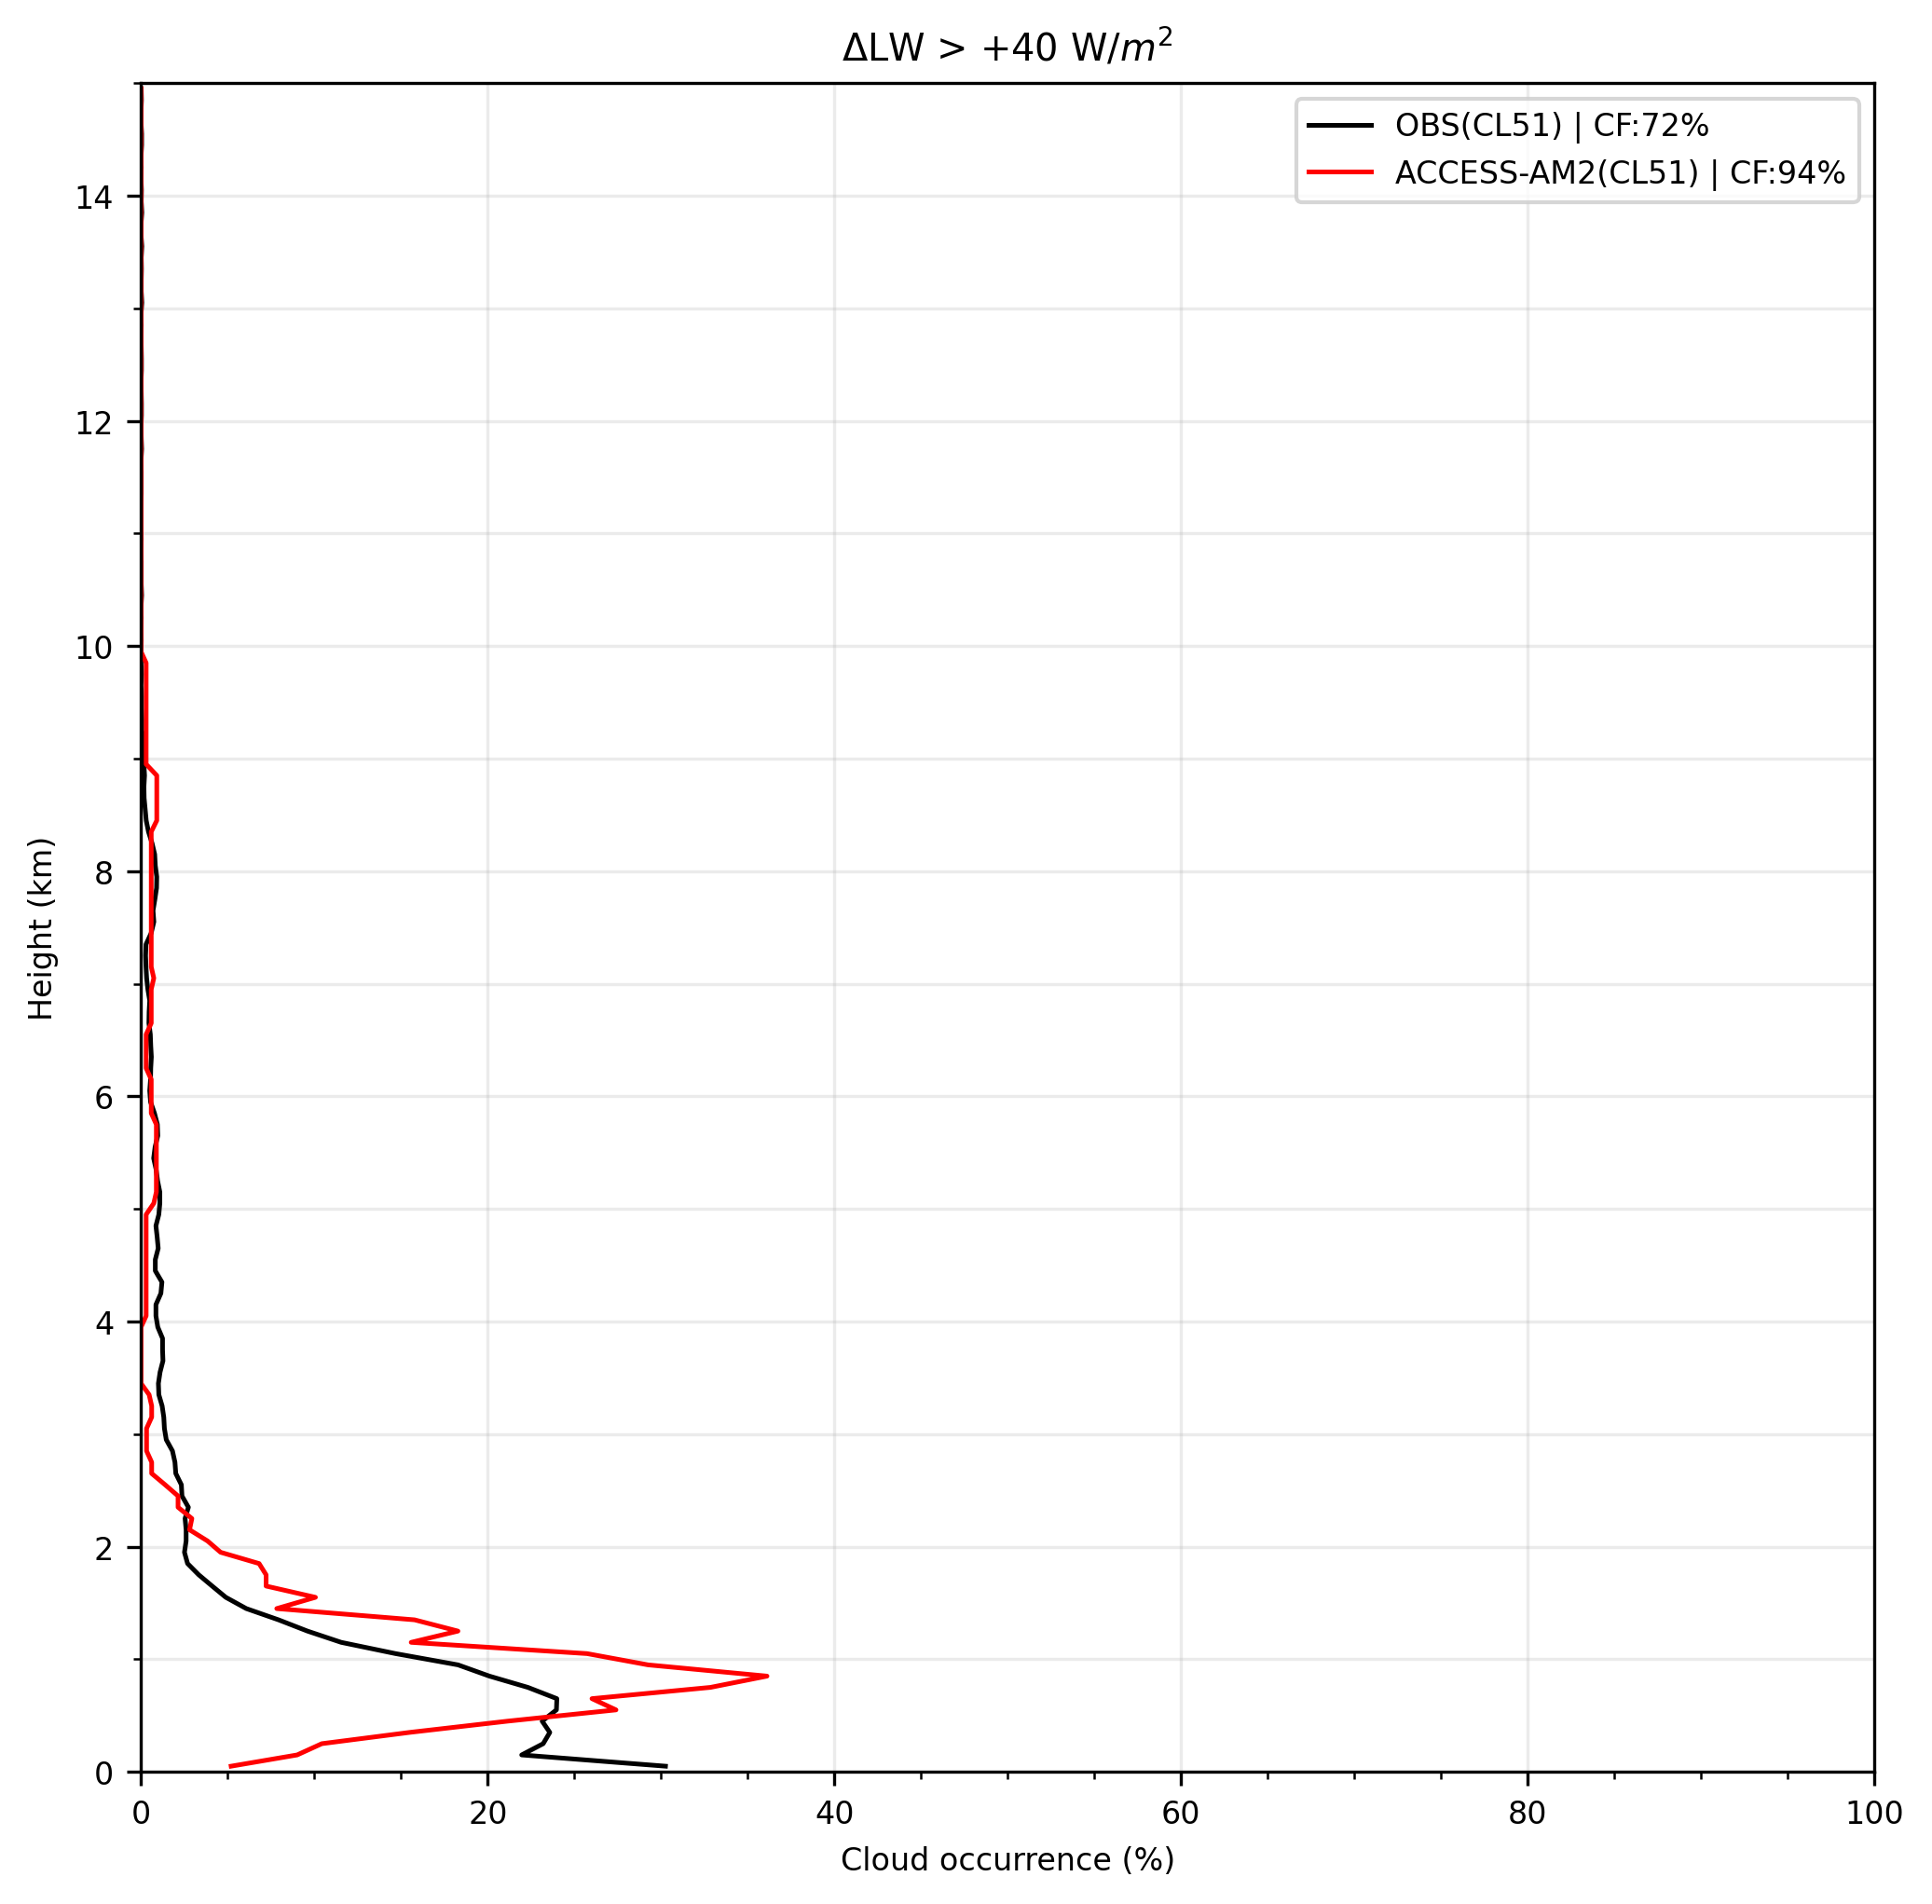

In [62]:
fig = plt.figure(figsize=(8,8),dpi=300)
plt.subplots_adjust(hspace=0.5)
plt.rcParams.update({'font.size': 8})

ax1 = plt.subplot()
plt.plot(cl_posLW, 1e-3*h_posLW, color='k', linewidth = 1.2, label='OBS(CL51) | CF:72%');
plt.plot(cl1_posLW, 1e-3*h1_posLW, color='r', linewidth = 1.2, label='ACCESS-AM2(CL51) | CF:94%');
plt.xlim(0., 100.);
plt.ylim(0., 15000*1e-3);
plt.xlabel('Cloud occurrence (%)');
plt.ylabel('Height (km)');
plt.legend();
plt.title('$\Delta$LW > +40 W/$m^{2}$')

ax = plt.gca()
xmajorLocator = MultipleLocator(20)
xmajorFormatter = FormatStrFormatter('%1.1f')
xminorLocator = MultipleLocator(5) 
ymajorLocator = MultipleLocator(2)
ymajorFormatter = FormatStrFormatter('%1.1f')
yminorLocator = MultipleLocator(1) 

ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)

ax.xaxis.grid(True, which='major', alpha=0.25)
ax.yaxis.grid(True, which='major', alpha=0.25)
ax.yaxis.grid(True, which='minor', alpha=0.25)

plt.show()

In [63]:
fdir = '/Users/peizhangcheng/Desktop/ALCF/MQI_Ceilometer/MI_negCRE/alcf_cl51_stats.nc'
cl51_stats_negCRE = xr.open_dataset(fdir)

In [64]:
cl51_stats_negCRE

<xarray.Dataset>
Dimensions:              (backscatter_full: 39, backscatter_sd_full: 13, zfull: 150)
Coordinates:
  * zfull                (zfull) float64 50.0 150.0 ... 1.485e+04 1.495e+04
  * backscatter_full     (backscatter_full) float64 7.5e-06 ... 0.0001975
  * backscatter_sd_full  (backscatter_sd_full) float64 1.5e-09 ... 6.144e-06
Data variables:
    cl                   (zfull) float64 ...
    clt                  float64 ...
    n                    int64 ...
    backscatter_avg      (zfull) float64 ...
    backscatter_mol_avg  (zfull) float64 ...
    backscatter_hist     (backscatter_full, zfull) float64 ...
    backscatter_sd_hist  (backscatter_sd_full) float64 ...
    backscatter_sd_z     float64 ...

In [65]:
fdir = '/Volumes/My Passport/ALCF/alcf-tutorial-datasets/ACCESS_CREbias_neg/alcf_stats.nc'
access_stats_negCRE = xr.open_dataset(fdir)

In [66]:
access_stats_negCRE

<xarray.Dataset>
Dimensions:              (backscatter_full: 39, backscatter_sd_full: 13, column: 10, zfull: 150)
Coordinates:
  * zfull                (zfull) float64 50.0 150.0 ... 1.485e+04 1.495e+04
  * backscatter_full     (backscatter_full) float64 7.5e-06 ... 0.0001975
  * backscatter_sd_full  (backscatter_sd_full) float64 1.5e-09 ... 6.144e-06
Dimensions without coordinates: column
Data variables:
    cl                   (zfull, column) float64 ...
    clt                  (column) float64 ...
    n                    (column) int64 ...
    backscatter_avg      (zfull, column) float64 ...
    backscatter_mol_avg  (zfull, column) float64 ...
    backscatter_hist     (backscatter_full, zfull, column) float64 ...
    backscatter_sd_hist  (backscatter_sd_full, column) float64 ...
    backscatter_sd_z     float64 ...

In [67]:
h_negCRE = pd.Series(cl51_stats_negCRE.zfull)
cl_negCRE = pd.Series(cl51_stats_negCRE.cl)

In [68]:
h1_negCRE = pd.Series(access_stats_negCRE.zfull)
cl1_negCRE = access_stats_negCRE.cl.sel(column=0)

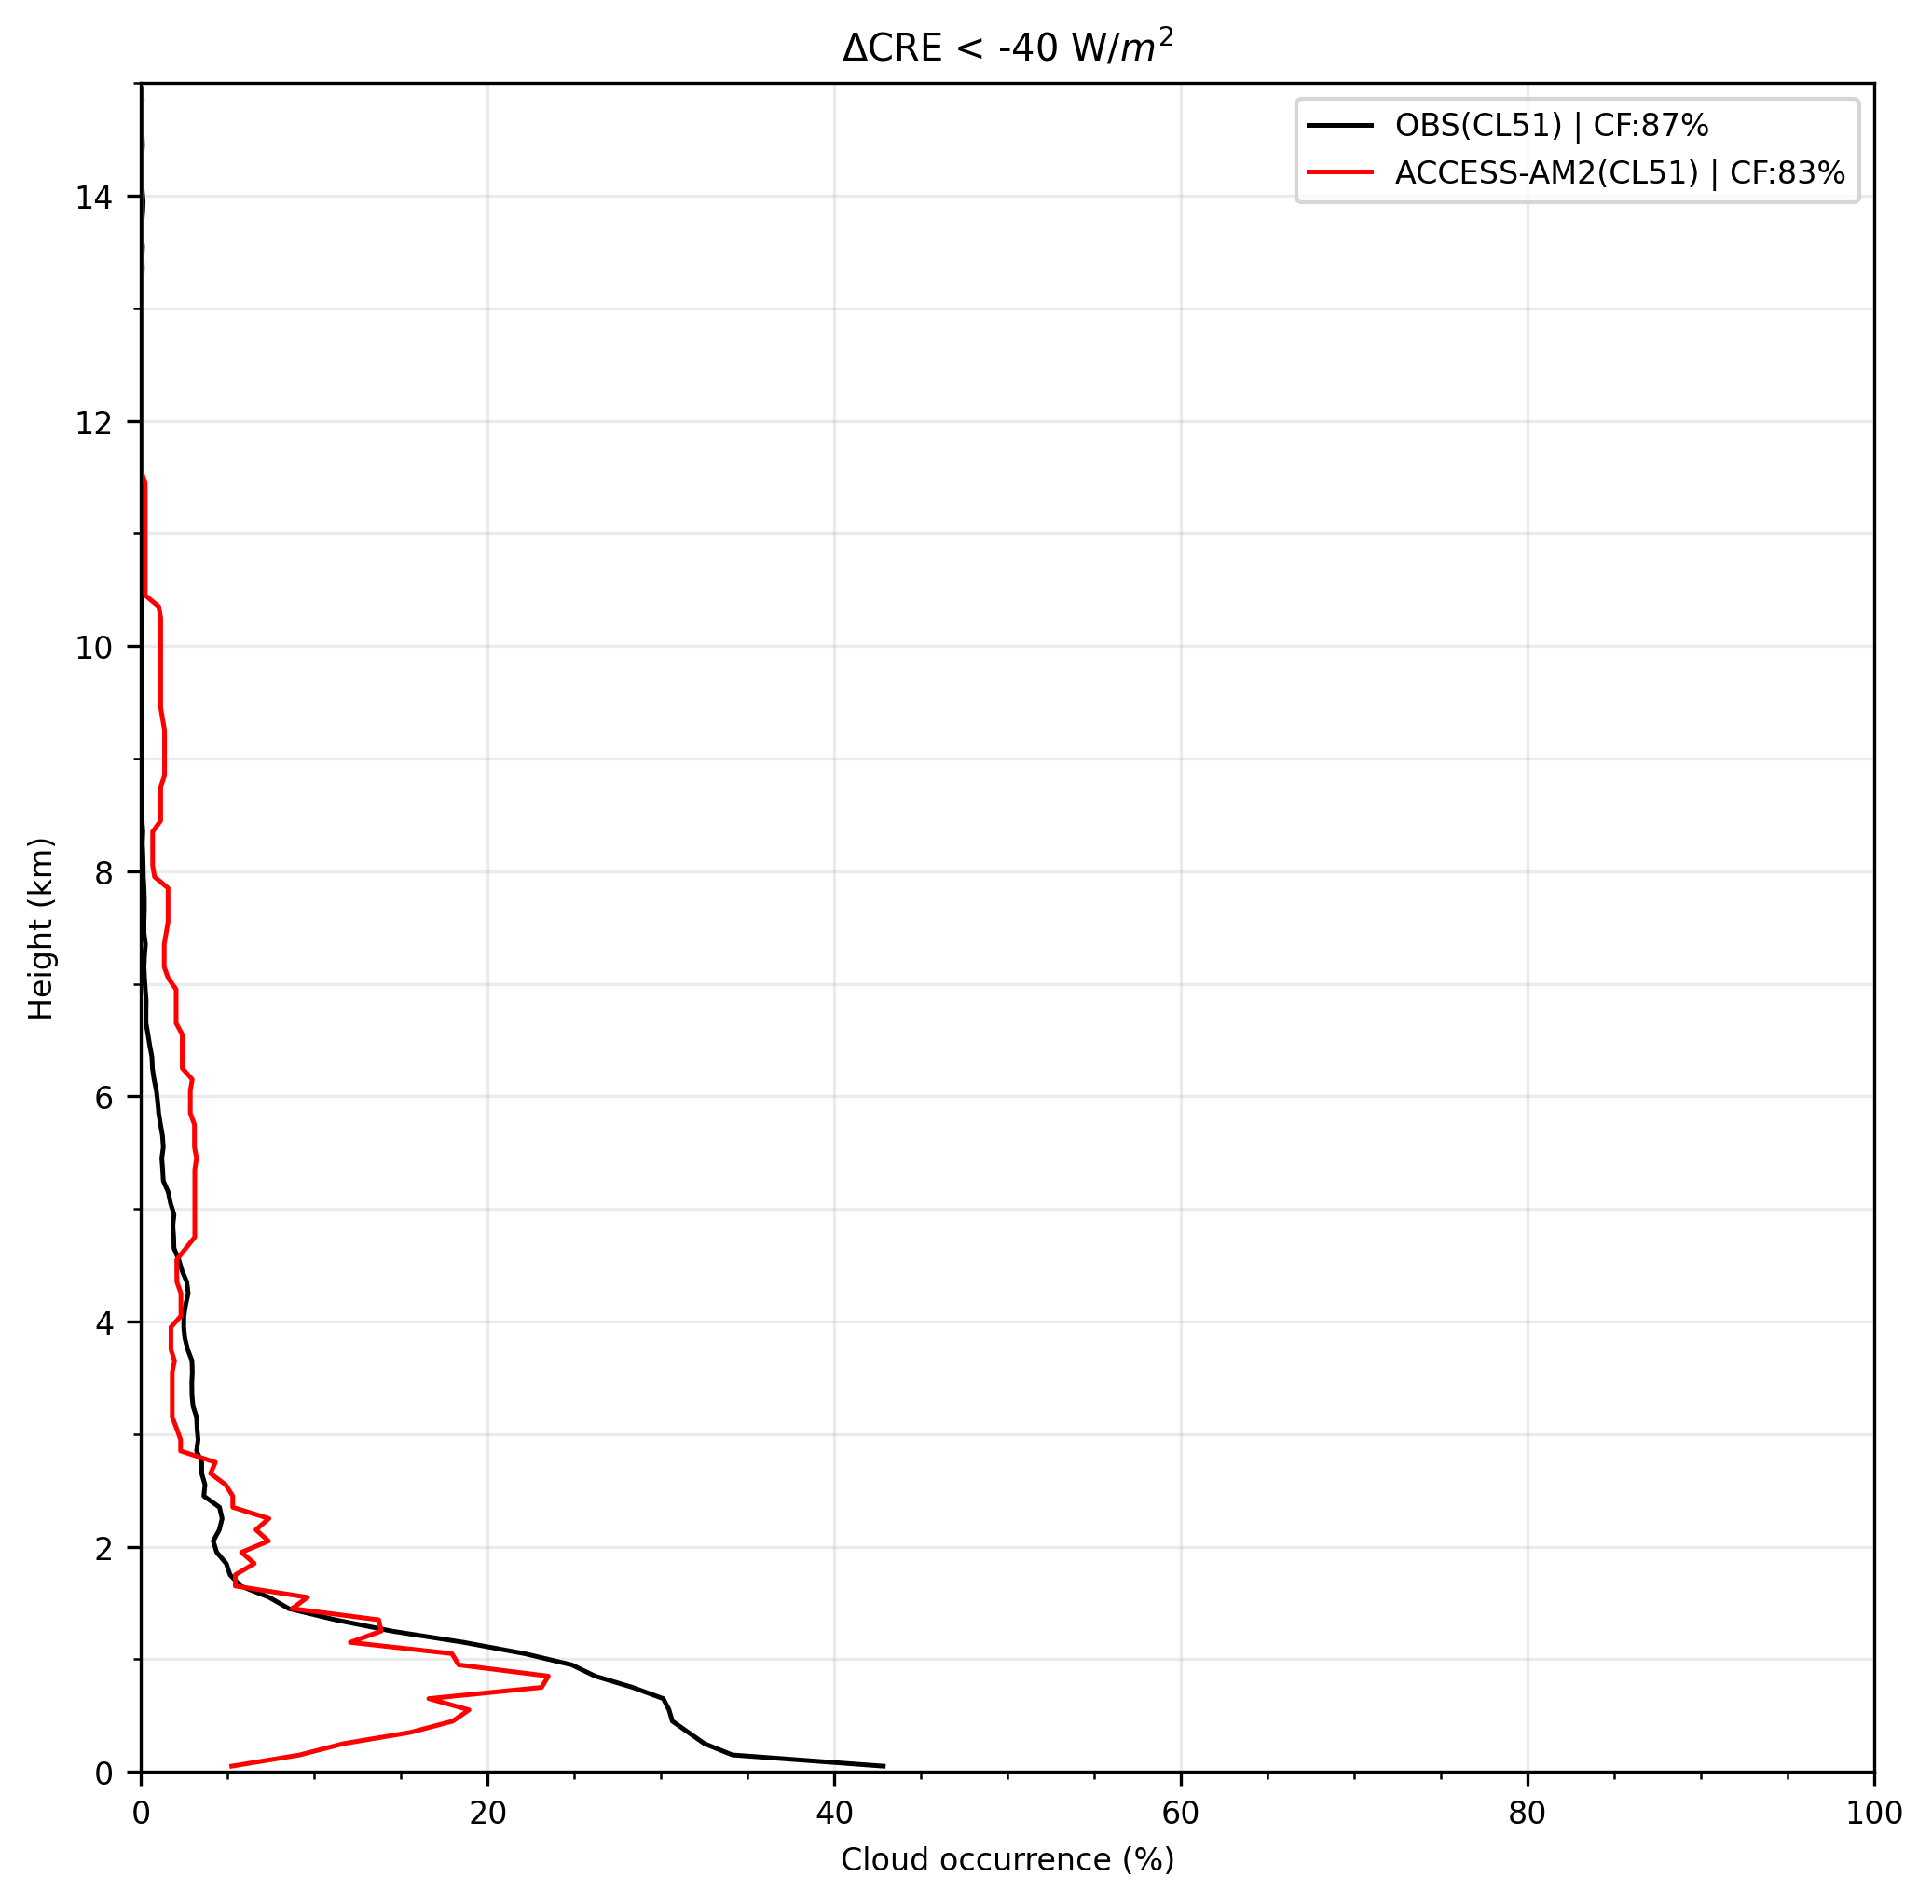

In [69]:
fig = plt.figure(figsize=(8,8),dpi=300)
plt.subplots_adjust(hspace=0.5)
plt.rcParams.update({'font.size': 8})

ax1 = plt.subplot()
plt.plot(cl_negCRE, 1e-3*h_negCRE, color='k', linewidth = 1.2, label='OBS(CL51) | CF:87%');
plt.plot(cl1_negCRE, 1e-3*h1_negCRE, color='r', linewidth = 1.2, label='ACCESS-AM2(CL51) | CF:83%');
plt.xlim(0., 100.);
plt.ylim(0., 15000*1e-3);
plt.xlabel('Cloud occurrence (%)');
plt.ylabel('Height (km)');
plt.legend();
plt.title('$\Delta$CRE < -40 W/$m^{2}$')

ax = plt.gca()
xmajorLocator = MultipleLocator(20)
xmajorFormatter = FormatStrFormatter('%1.1f')
xminorLocator = MultipleLocator(5) 
ymajorLocator = MultipleLocator(2)
ymajorFormatter = FormatStrFormatter('%1.1f')
yminorLocator = MultipleLocator(1) 

ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)

ax.xaxis.grid(True, which='major', alpha=0.25)
ax.yaxis.grid(True, which='major', alpha=0.25)
ax.yaxis.grid(True, which='minor', alpha=0.25)

plt.show()

In [70]:
fdir = '/Users/peizhangcheng/Desktop/ALCF/MQI_Ceilometer/MI_posCRE/alcf_cl51_stats.nc'
cl51_stats_posCRE = xr.open_dataset(fdir)

In [71]:
cl51_stats_posCRE

<xarray.Dataset>
Dimensions:              (backscatter_full: 39, backscatter_sd_full: 13, zfull: 150)
Coordinates:
  * zfull                (zfull) float64 50.0 150.0 ... 1.485e+04 1.495e+04
  * backscatter_full     (backscatter_full) float64 7.5e-06 ... 0.0001975
  * backscatter_sd_full  (backscatter_sd_full) float64 1.5e-09 ... 6.144e-06
Data variables:
    cl                   (zfull) float64 ...
    clt                  float64 ...
    n                    int64 ...
    backscatter_avg      (zfull) float64 ...
    backscatter_mol_avg  (zfull) float64 ...
    backscatter_hist     (backscatter_full, zfull) float64 ...
    backscatter_sd_hist  (backscatter_sd_full) float64 ...
    backscatter_sd_z     float64 ...

In [72]:
fdir = '/Volumes/My Passport/ALCF/alcf-tutorial-datasets/ACCESS_CREbias_pos/alcf_stats.nc'
access_stats_posCRE = xr.open_dataset(fdir)

In [73]:
access_stats_posCRE

<xarray.Dataset>
Dimensions:              (backscatter_full: 39, backscatter_sd_full: 13, column: 10, zfull: 150)
Coordinates:
  * zfull                (zfull) float64 50.0 150.0 ... 1.485e+04 1.495e+04
  * backscatter_full     (backscatter_full) float64 7.5e-06 ... 0.0001975
  * backscatter_sd_full  (backscatter_sd_full) float64 1.5e-09 ... 6.144e-06
Dimensions without coordinates: column
Data variables:
    cl                   (zfull, column) float64 ...
    clt                  (column) float64 ...
    n                    (column) int64 ...
    backscatter_avg      (zfull, column) float64 ...
    backscatter_mol_avg  (zfull, column) float64 ...
    backscatter_hist     (backscatter_full, zfull, column) float64 ...
    backscatter_sd_hist  (backscatter_sd_full, column) float64 ...
    backscatter_sd_z     float64 ...

In [74]:
h_posCRE = pd.Series(cl51_stats_posCRE.zfull)
cl_posCRE = pd.Series(cl51_stats_posCRE.cl)

In [75]:
h1_posCRE = pd.Series(access_stats_posCRE.zfull)
cl1_posCRE = access_stats_posCRE.cl.sel(column=0)

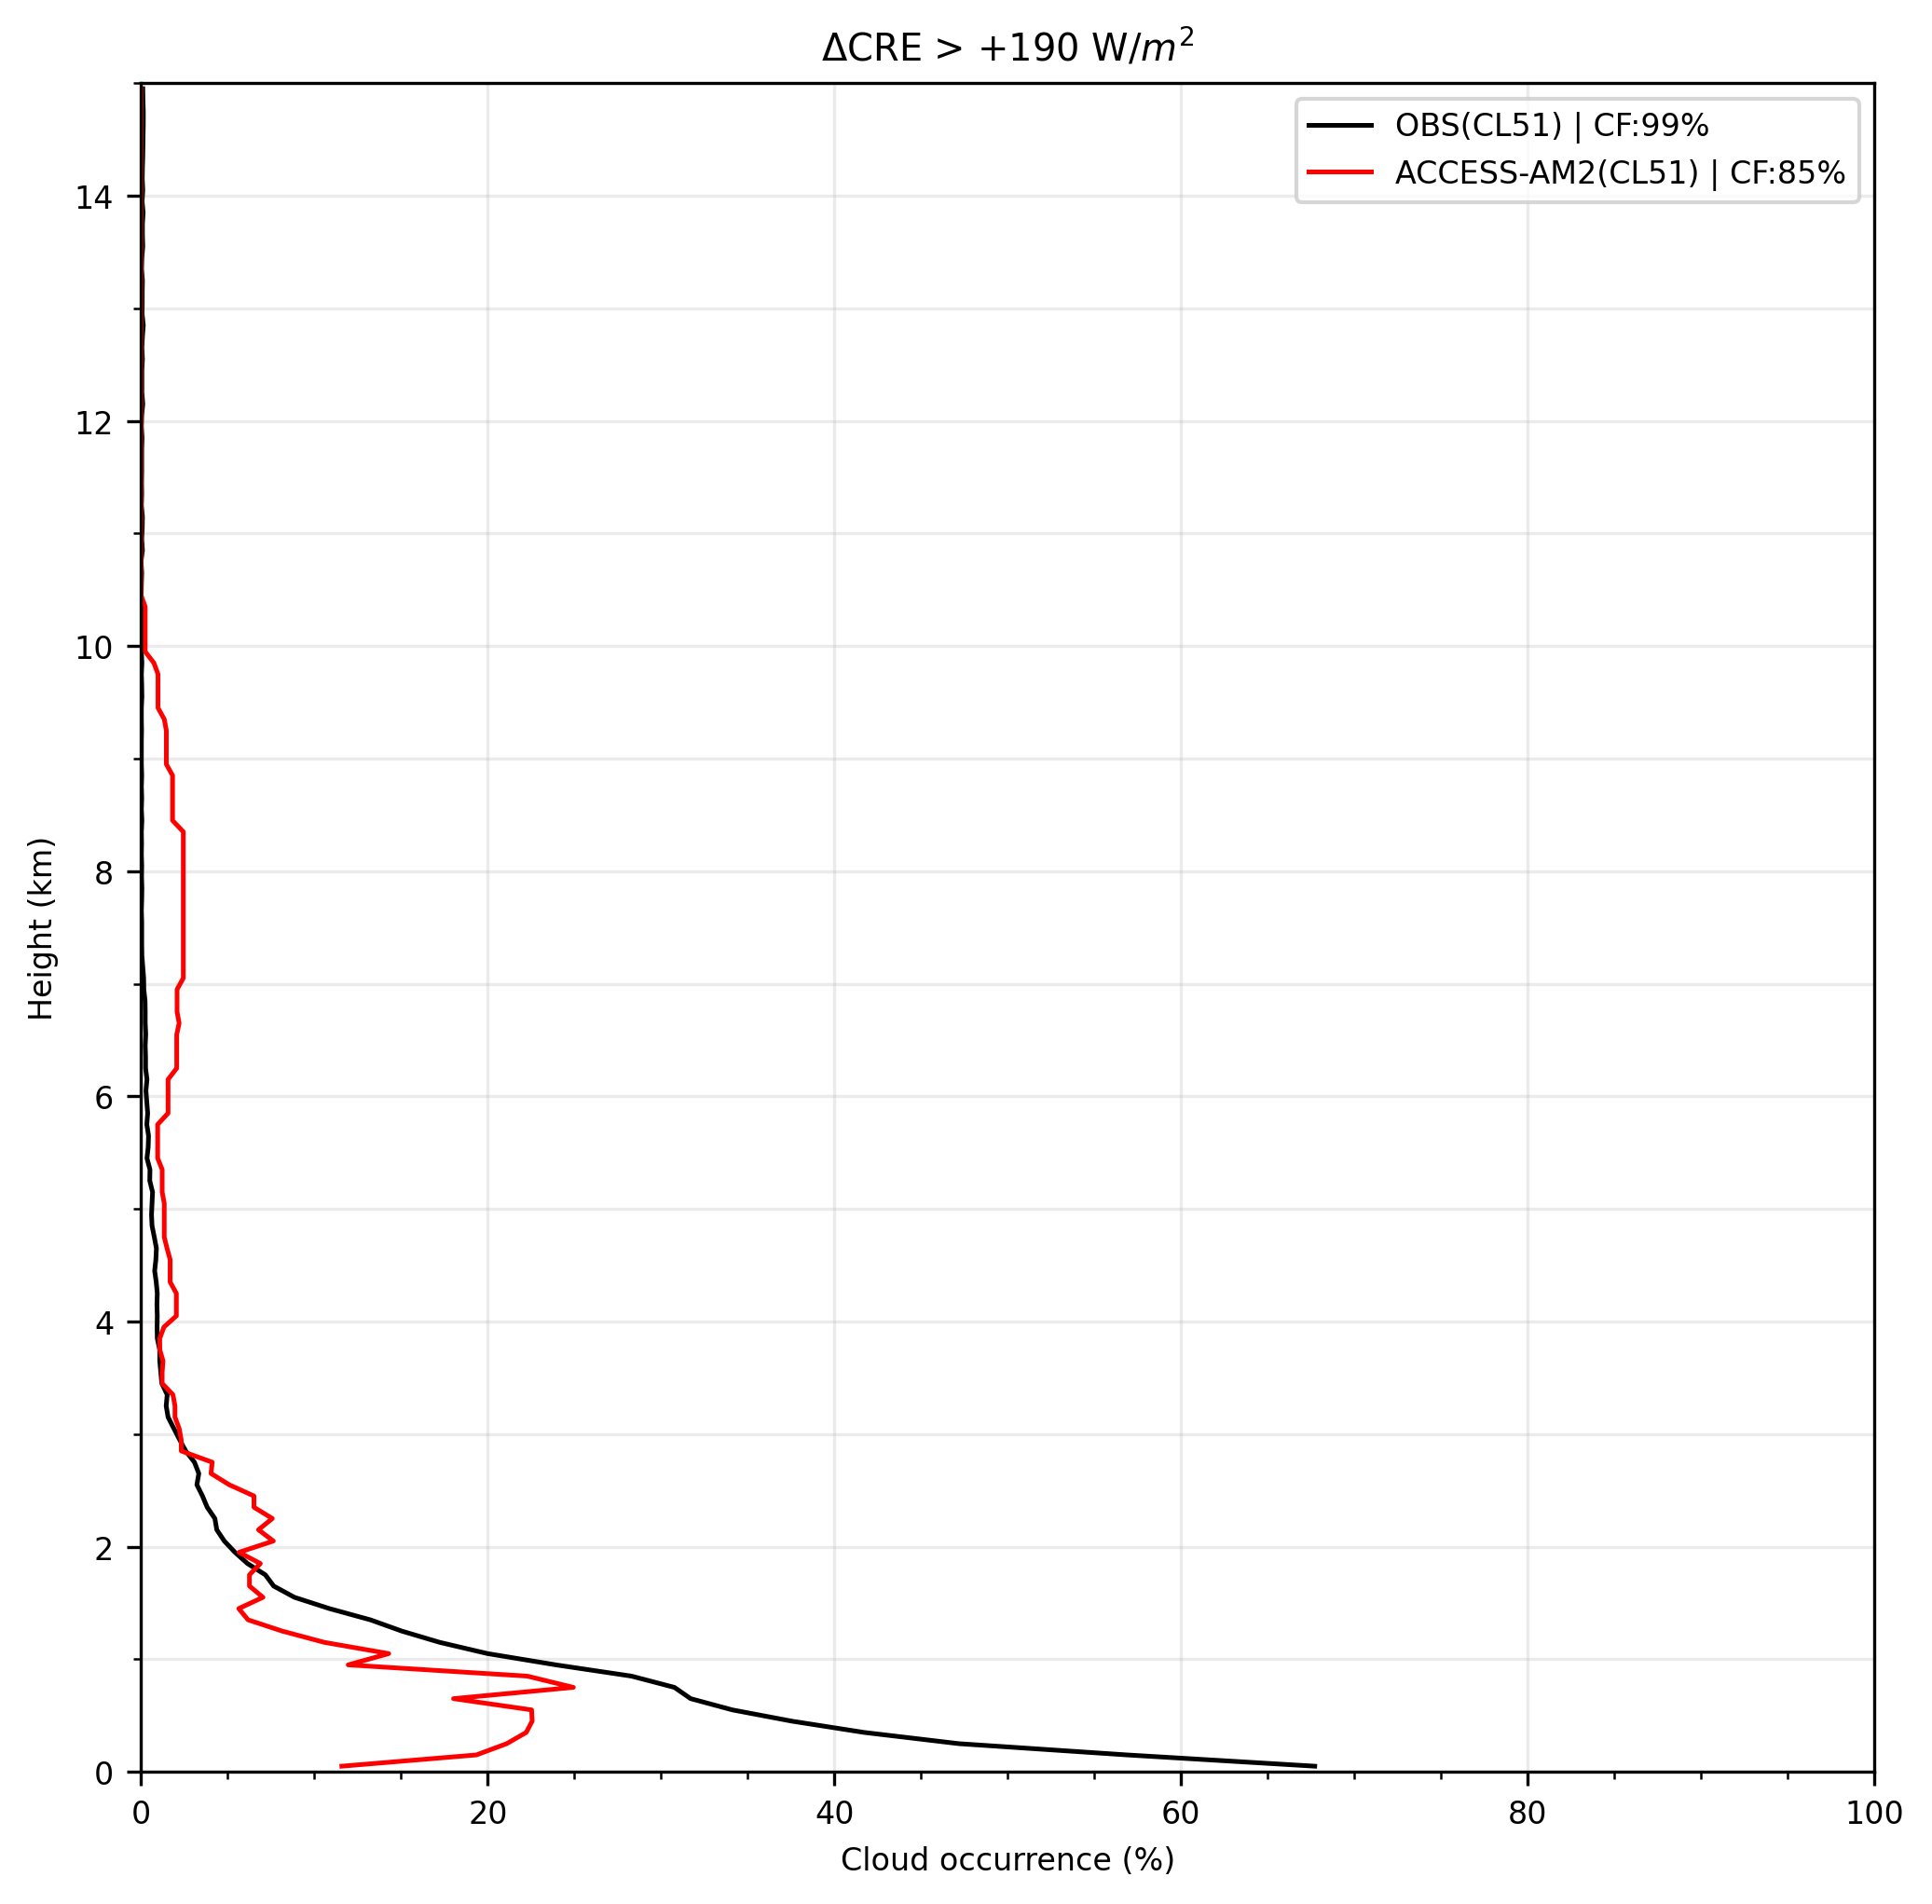

In [76]:
fig = plt.figure(figsize=(8,8),dpi=300)
plt.subplots_adjust(hspace=0.5)
plt.rcParams.update({'font.size': 8})

ax1 = plt.subplot()
plt.plot(cl_posCRE, 1e-3*h_posCRE, color='k', linewidth = 1.2, label='OBS(CL51) | CF:99%');
plt.plot(cl1_posCRE, 1e-3*h1_posCRE, color='r', linewidth = 1.2, label='ACCESS-AM2(CL51) | CF:85%');
plt.xlim(0., 100.);
plt.ylim(0., 15000*1e-3);
plt.xlabel('Cloud occurrence (%)');
plt.ylabel('Height (km)');
plt.legend();
plt.title('$\Delta$CRE > +190 W/$m^{2}$')

ax = plt.gca()
xmajorLocator = MultipleLocator(20)
xmajorFormatter = FormatStrFormatter('%1.1f')
xminorLocator = MultipleLocator(5) 
ymajorLocator = MultipleLocator(2)
ymajorFormatter = FormatStrFormatter('%1.1f')
yminorLocator = MultipleLocator(1) 

ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)

ax.xaxis.grid(True, which='major', alpha=0.25)
ax.yaxis.grid(True, which='major', alpha=0.25)
ax.yaxis.grid(True, which='minor', alpha=0.25)

plt.show()